Projekt oparty na konkursie Kaggle [Adaptive Immune Profiling Challenge 2025](https://www.kaggle.com/competitions/adaptive-immune-profiling-challenge-2025)

# Wprowadzenie teoretyczne: Repertuary immunologiczne i zadanie klasyfikacji

## Czym są repertuary immunologiczne?

**Adaptacyjny repertuar receptorów immunologicznych (Adaptive Immune Receptor Repertoire, AIRR)** — to zbiór wszystkich receptorów komórek immunologicznych (limfocytów T i B) u konkretnej osoby w określonym momencie czasu. Każdy receptor to unikalna sekwencja białkowa, zdolna do rozpoznawania specyficznych antygenów (obcych cząsteczek, patogenów, komórek nowotworowych).

### Receptory komórek T (TCR)

**Receptory komórek T (TCR)** — to białka na powierzchni limfocytów T, które rozpoznają antygeny. Każdy TCR składa się z:
- **Genu V** (Variable) — określa region zmienny
- **Genu D** (Diversity) — obecny tylko w łańcuchu β
- **Genu J** (Joining) — określa region łączący
- **CDR3 (Complementarity Determining Region 3)** — najbardziej zmienny fragment, określający specyficzność receptora

**Junction (junction_aa)** — to sekwencja aminokwasowa CDR3, która jest kodowana przez kombinację genów V, D, J i jest unikalna dla każdego receptora.
Ta sama sekwencja aminokwasowa `junction_aa` teoretycznie może być uzyskana przez różne kombinacje genów V, D, J, chociaż w praktyce jest to rzadkość ze względu na specyfikę rekombinacji.

## Zadanie konkursu AIRR-ML-25

Konkurs [Adaptive Immune Profiling Challenge 2025](https://www.kaggle.com/competitions/adaptive-immune-profiling-challenge-2025) stawia przed uczestnikami **dwa powiązane zadania**:

### Zadanie 1: Przewidywanie stanu immunologicznego (Immune-state prediction)
**Cel**: Sklasyfikować, czy osoba jest zdrowa czy ma chorobę, opierając się **wyłącznie na danych jej repertuaru immunologicznego** (sekwencjach TCR).

- **Dane wejściowe**: Repertuar TCR osoby (tysiące/miliony sekwencji)
- **Wyjście**: Prawdopodobieństwo, że osoba ma chorobę (`label_positive_probability`)
- **Metryka**: ROC AUC

### Zadanie 2: Odkrywanie istotnych receptorów (Receptor discovery)
**Cel**: Zidentyfikować konkretne sekwencje TCR, które są **najbardziej związane z chorobą**.

- **Dane wejściowe**: Zbiory treningowe ze znanymi etykietami
- **Wyjście**: Top 50,000 sekwencji (`junction_aa`, `v_call`, `j_call`) dla każdego zbioru treningowego
- **Metryka**: Jaccard Score (przecięcie z referencyjnym zbiorem istotnych sekwencji)

## Dlaczego to ważne?

1. **Wczesna diagnostyka**: Możliwość wykrywania chorób na podstawie repertuaru immunologicznego przed pojawieniem się objawów klinicznych
2. **Medycyna spersonalizowana**: Zrozumienie indywidualnych wzorców immunologicznych
3. **Biomarkery**: Odkrywanie specyficznych sekwencji TCR jako markerów chorób
4. **Immunoterapia**: Opracowywanie ukierunkowanych metod leczenia na podstawie profili TCR

## Struktura danych

Każdy dataset to osobne badanie (kohorta). W badaniu choroby nr 1 wiemy, kto jest chory na tę konkretną chorobę, a kto jest zdrową kontrolą z tej samej grupy pacjentów. Nie znamy statusu tych osób względem choroby nr 2 z innego badania, czyli zdrowa osoba z pierwszego datasetu może być chora w drugim.

---

# EDA: Eksploracyjna analiza danych cech



In [ ]:
import os
import re
import pandas as pd
import numpy as np
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from utils import validate_sequences_in_datasets, compute_repertoire_features

# Konfiguracja wizualizacji
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Wykrywanie środowiska: Kaggle lub lokalne
IS_KAGGLE = os.path.exists('/kaggle/input')

if IS_KAGGLE:
    DATA_DIR = Path('/kaggle/input/adaptive-immune-profiling-challenge-2025')
else:
    DATA_DIR = Path('../data')

TRAIN_DIR = DATA_DIR / 'train_datasets'
TEST_DIR = DATA_DIR / 'test_datasets'

print(f"Uruchomiono na: {'Kaggle' if IS_KAGGLE else 'Lokalnie'}")
print(f"Katalog danych: {DATA_DIR}")


Plotly zainicjalizowany dla interaktywnych wykresów
Uruchomiono na: Lokalnie
Katalog danych: ../data


#### Eksploracja zbiorów treningowych
W zbiorach treningowych są metadane z etykietami (label_positive)

Każdy dataset reprezentuje osobne badanie z różnym rozkładem klas

In [2]:
train_datasets = sorted([d for d in TRAIN_DIR.iterdir() if d.is_dir() and d.name.startswith('train_dataset')])
print(f"Znaleziono {len(train_datasets)} zbiorów TRENINGOWYCH:")
for d in train_datasets:
    metadata = pd.read_csv(d / 'metadata.csv')
    n_pos = metadata['label_positive'].sum()
    n_neg = len(metadata) - n_pos
    print(f"  {d.name}: {len(metadata)} próbek (poz={n_pos}, neg={n_neg})")


Znaleziono 8 zbiorów TRENINGOWYCH:
  train_dataset_1: 400 próbek (poz=200, neg=200)
  train_dataset_2: 400 próbek (poz=200, neg=200)
  train_dataset_3: 400 próbek (poz=200, neg=200)
  train_dataset_4: 400 próbek (poz=200, neg=200)
  train_dataset_5: 400 próbek (poz=200, neg=200)
  train_dataset_6: 400 próbek (poz=200, neg=200)
  train_dataset_7: 91 próbek (poz=14, neg=77)
  train_dataset_8: 182 próbek (poz=60, neg=122)


### Eksploracja zbiorów testowych
W zbiorach testowych nie ma metadanych z etykietami - to dane do przewidywania

Każdy plik .tsv zawiera sekwencje TCR jednego repertuaru

In [3]:
test_datasets = sorted([d for d in TEST_DIR.iterdir() if d.is_dir() and d.name.startswith('test_dataset')])
print(f"Znaleziono {len(test_datasets)} zbiorów TESTOWYCH:")
for d in test_datasets:
    n_files = len(list(d.glob('*.tsv')))
    print(f"  {d.name}: {n_files} plików")


Znaleziono 11 zbiorów TESTOWYCH:
  test_dataset_1: 400 plików
  test_dataset_2: 400 plików
  test_dataset_3: 400 plików
  test_dataset_4: 400 plików
  test_dataset_5: 400 plików
  test_dataset_6: 400 plików
  test_dataset_7_1: 76 plików
  test_dataset_7_2: 100 plików
  test_dataset_8_1: 390 plików
  test_dataset_8_2: 857 plików
  test_dataset_8_3: 390 plików


## Struktura danych

Każda próbka (repertuar) zawiera:
- **Metadane**: lista ID pacjentów (i nazwa odpowiedniego pliku z repertuarami) informacja o tym, czy pacjent jest chory czy zdrowy. Dla datasetów 7 i 8 dodatkowo są informacje demograficzne (tylko w train) i geny HLA (tylko w train), ale ponieważ w teście tych informacji nie ma, zdecydowałam się w ramach projektu nie używać tych informacji.
- **Sekwencje TCR**: pliki z tysiącami sekwencji, każda zawiera:
  - `junction_aa` — sekwencja aminokwasowa CDR3 (wynik rekombinacji genów V, D, J)
  - `v_call`, `j_call`, `d_call` — **osobne kolumny**, wskazujące które dokładnie geny zostały użyte do stworzenia tej sekwencji
  - `templates` — liczba kopii sekwencji (częstość w repertuarze)

In [4]:
# Ładujemy wszystkie metadane ze wszystkich zbiorów treningowych
all_metadata = []
for train_ds in train_datasets:
    metadata = pd.read_csv(train_ds / 'metadata.csv')
    metadata['dataset'] = train_ds.name
    all_metadata.append(metadata)

metadata_all = pd.concat(all_metadata, ignore_index=True)
print(f"\nRozkład według datasetów:")
print(metadata_all['dataset'].value_counts().sort_index())


Rozkład według datasetów:
dataset
train_dataset_1    400
train_dataset_2    400
train_dataset_3    400
train_dataset_4    400
train_dataset_5    400
train_dataset_6    400
train_dataset_7     91
train_dataset_8    182
Name: count, dtype: int64


In [5]:
# Ładujemy jedną próbkę treningową i przyglądamy się danym

train_dir = TRAIN_DIR / 'train_dataset_8'
metadata = pd.read_csv(train_dir / 'metadata.csv')
print(f"Kolumny metadanych w 8. datasecie: \n{metadata.columns.tolist()}")
metadata.head()

Kolumny metadanych w 8. datasecie: 
['repertoire_id', 'filename', 'label_positive', 'study_group_description', 'sex', 'age', 'A', 'B', 'C', 'DPA1', 'DPB1', 'DQA1', 'DQB1', 'DRB1', 'DRB3', 'DRB4', 'DRB5']


,repertoire_id,filename,label_positive,study_group_description,sex,age,A,B,C,DPA1,DPB1,DQA1,DQB1,DRB1,DRB3,DRB4,DRB5
0,35579ef36d2bd41ac5fa48f3fa857cbd,35579ef36d2bd41ac5fa48f3fa857cbd.tsv,True,T1D,M,16.410678,202;6601,1402;4403,802;1402,103;103,401;1701,101;201,501;202,701;1401,202;9901,9901;101,9901;9901
1,18a691eaf2529bc454a38e4412ceee3b,18a691eaf2529bc454a38e4412ceee3b.tsv,False,CTRL,M,45.850787,2902;6801,4403;1801,1203;1601,103;103,301;301,102;401,602;402,801;1501,9901;9901,9901;9901,101;9901
2,375af39e7f5d71d904a547d38bef37ca,375af39e7f5d71d904a547d38bef37ca.tsv,False,CTRL,F,42.989733,2402;301,1402;702,802;702,103;103,401;401,501;102,201;602,301;1501,9901;101,9901;9901,101;9901
3,619c11d0ba0c4812715813890f0ce2fd,619c11d0ba0c4812715813890f0ce2fd.tsv,True,T1D,M,17.130732,301;6802,702;1402,802;702,103;201,401;101,501;201,201;202,701;301,9901;101,9901;101,9901;9901
4,fd1702b1d6c53e42743cf050e962e986,fd1702b1d6c53e42743cf050e962e986.tsv,False,SDR,F,25.733060,201;201,5701;4403,1601;602,201;103,1101;401,201;201,303;202,701;701,9901;9901,103;101,9901;9901


In [6]:
print(f"\nPierwsza próbka:")
sample_file = train_dir / metadata.iloc[0]['filename']
df_sample = pd.read_csv(sample_file, sep='\t')
print(f"Kolumny pliku TCR: {df_sample.columns.tolist()}")
print(f"Sekwencje TCR w pliku: {len(df_sample)}")
df_sample.head()


Pierwsza próbka:
Kolumny pliku TCR: ['junction_aa', 'v_call', 'j_call', 'd_call', 'templates']
Sekwencje TCR w pliku: 92412


,junction_aa,v_call,j_call,d_call,templates
0,AESGRETDTQYF,TCRBV06-04,TCRBJ02-03,TCRBD02-01,3
1,AGGPLDGYEQYF,TCRBV20,TCRBJ02-07,TCRBD01-01,1
2,ALNAQTHNEKLFF,TCRBV03-01/03-02,TCRBJ01-04,TCRBD01-01,1
3,ANGRGYTDTQYF,TCRBV28-01,TCRBJ02-03,TCRBD02-01,1
4,ANVLTF,TCRBV03-01/03-02,TCRBJ02-06,unknown,1


In [7]:
# Załaduj jedną próbkę treningową i przyjrzyj się danym
train_dir = TRAIN_DIR / 'train_dataset_1'
metadata = pd.read_csv(train_dir / 'metadata.csv')
print(f"Kolumny metadanych w 1. zbiorze danych: \n{metadata.columns.tolist()}")
metadata.head()

Kolumny metadanych w 1. zbiorze danych: 
['repertoire_id', 'filename', 'label_positive']


,repertoire_id,filename,label_positive
0,44967b361684556629a8b61288daf20c,44967b361684556629a8b61288daf20c.tsv,True
1,36c146e43178cc60d3694117e85cf8f0,36c146e43178cc60d3694117e85cf8f0.tsv,False
2,90e072812957e184a00d7dd6e6fc1113,90e072812957e184a00d7dd6e6fc1113.tsv,False
3,e067bc70fd5eb332289ab527ee07b10e,e067bc70fd5eb332289ab527ee07b10e.tsv,True
4,e23d10263fd2069cdf5d7033532d11ad,e23d10263fd2069cdf5d7033532d11ad.tsv,False


In [8]:
print(f"\nPierwsza próbka:")
sample_file = train_dir / metadata.iloc[0]['filename']
df_sample = pd.read_csv(sample_file, sep='\t')
print(f"Kolumny pliku TCR: {df_sample.columns.tolist()}")
print(f"Sekwencje TCR w pliku: {len(df_sample)}")
df_sample.head()



Pierwsza próbka:
Kolumny pliku TCR: ['junction_aa', 'v_call', 'j_call']
Sekwencje TCR w pliku: 25000


,junction_aa,v_call,j_call
0,CASSQIPELDLLLDTQYF,TRBV3-1,TRBJ2-3
1,CASSLGGFGGNEQFF,TRBV7-6,TRBJ2-1
2,CSASPGPDEQFF,TRBV20-1,TRBJ2-1
3,CASIHRRGVGEQFF,TRBV27,TRBJ2-1
4,CASSPPRGSTGNTIYF,TRBV4-1,TRBJ1-3


## Struktura zgłoszenia

Zgłoszenie składa się z **dwóch części**:

1. **Wiersze 1-4213**: Przewiduj `label_positive_probability` dla każdego repertuaru testowego
2. **Wiersze 4214-404213**: Zwróć top 50k ważnych sekwencji (`junction_aa`, `v_call`, `j_call`) dla każdego zbioru treningowego

Podział następuje według specjalnych wartości-markerów (-999.0)

In [9]:
sample_sub = pd.read_csv('../data/sample_submissions.csv')
print("Podział zgłoszenia:")
print(f"  Łączna liczba wierszy: {len(sample_sub)}")

# W pierwszej części dla każdego repertuaru testowego należy przewidzieć prawdopodobieństwo choroby
pred_mask = sample_sub['label_positive_probability'] != -999.0
print(f"  Część 1 - Przewidywania: {pred_mask.sum()} wierszy")

# W drugiej części należy zwrócić top-50k sekwencji TCR związanych z chorobą
# dla każdego zbioru treningowego (po 50k na zbiór)
seq_mask = sample_sub['junction_aa'] != '-999.0'
print(f"  Część 2 - Sekwencje: {seq_mask.sum()} wierszy")

# Sprawdzamy rozkład sekwencji według zbiorów treningowych
print(f"\n  Sekwencje na zbiór treningowy:")
seq_datasets = sample_sub[seq_mask]['dataset'].value_counts().sort_index()
for ds, count in seq_datasets.items():
    print(f"    {ds}: {count}")


Podział zgłoszenia:
  Łączna liczba wierszy: 404213
  Część 1 - Przewidywania: 4213 wierszy
  Część 2 - Sekwencje: 400000 wierszy

  Sekwencje na zbiór treningowy:
    train_dataset_1: 50000
    train_dataset_2: 50000
    train_dataset_3: 50000
    train_dataset_4: 50000
    train_dataset_5: 50000
    train_dataset_6: 50000
    train_dataset_7: 50000
    train_dataset_8: 50000


# EDA: Analiza metadanych (Metadata Features)

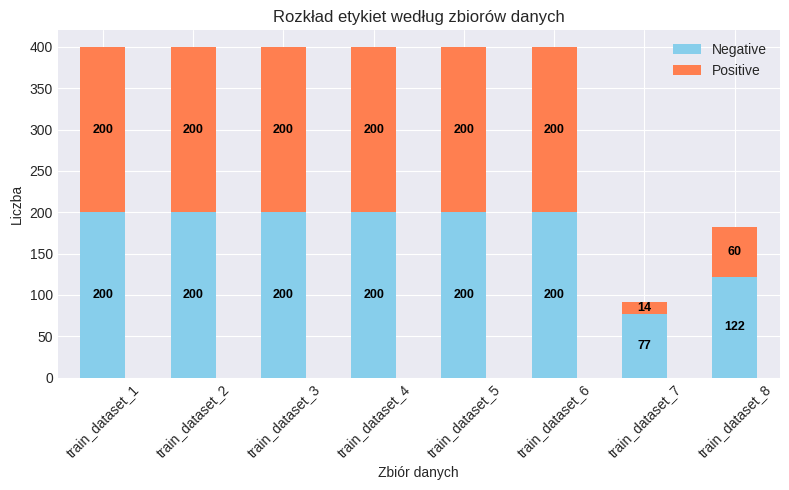

In [10]:
# Rozkład zmiennej docelowej
fig, axes = plt.subplots(1, 1, figsize=(8, 5))

# Rozkład według zbiorów danych
label_by_dataset = pd.crosstab(metadata_all['dataset'], metadata_all['label_positive'])
bars = label_by_dataset.plot(kind='bar', stacked=True, ax=axes, color=['skyblue', 'coral'])

# Dodajemy liczby na wykres
for idx, rects in enumerate(bars.containers):
    for rect in rects:
        height = rect.get_height()
        if height > 0:
            axes.annotate(f'{int(height)}',
                          xy=(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2),
                          ha='center', va='center', color='black', fontsize=9, fontweight='bold')
axes.set_title('Rozkład etykiet według zbiorów danych')
axes.set_xlabel('Zbiór danych')
axes.set_ylabel('Liczba')
axes.legend(['Negative', 'Positive'])
axes.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


W zbiorach danych 7 i 8 występuje niewielka nierównowaga klas.

# EDA: Analiza sekwencji TCR (Cechy sekwencji)

In [11]:
# Analiza struktury danych TCR na przykładzie jednego zbioru danych
train_dir = TRAIN_DIR / 'train_dataset_8'
metadata_sample = pd.read_csv(train_dir / 'metadata.csv')

# Ładujemy kilka próbek do analizy
sample_files = metadata_sample.head(30)['filename'].tolist()
sample_dfs = []

for filename in sample_files:
    df = pd.read_csv(train_dir / filename, sep='\t')
    df['repertoire_id'] = metadata_sample[metadata_sample['filename'] == filename]['repertoire_id'].values[0]
    df['label'] = metadata_sample[metadata_sample['filename'] == filename]['label_positive'].values[0]
    sample_dfs.append(df)

sample_combined = pd.concat(sample_dfs, ignore_index=True)
print(f"=== STRUKTURA DANYCH TCR ===")
print(f"Kolumny: {sample_combined.columns.tolist()}")
print(f"\nLiczba sekwencji w 30 próbkach: {len(sample_combined)}")
print(f"\nPierwsze wiersze:")
sample_combined.head(10)

=== STRUKTURA DANYCH TCR ===
Kolumny: ['junction_aa', 'v_call', 'j_call', 'd_call', 'templates', 'repertoire_id', 'label']

Liczba sekwencji w 30 próbkach: 3088786

Pierwsze wiersze:


,junction_aa,v_call,j_call,d_call,templates,repertoire_id,label
0,AESGRETDTQYF,TCRBV06-04,TCRBJ02-03,TCRBD02-01,3,35579ef36d2bd41ac5fa48f3fa857cbd,True
1,AGGPLDGYEQYF,TCRBV20,TCRBJ02-07,TCRBD01-01,1,35579ef36d2bd41ac5fa48f3fa857cbd,True
2,ALNAQTHNEKLFF,TCRBV03-01/03-02,TCRBJ01-04,TCRBD01-01,1,35579ef36d2bd41ac5fa48f3fa857cbd,True
3,ANGRGYTDTQYF,TCRBV28-01,TCRBJ02-03,TCRBD02-01,1,35579ef36d2bd41ac5fa48f3fa857cbd,True
4,ANVLTF,TCRBV03-01/03-02,TCRBJ02-06,unknown,1,35579ef36d2bd41ac5fa48f3fa857cbd,True
5,ARNTEAFF,TCRBV04,TCRBJ01-01,TCRBD02-01,2,35579ef36d2bd41ac5fa48f3fa857cbd,True
6,ASGTSYEQYF,TCRBV21-01,TCRBJ02-07,TCRBD02-01,2,35579ef36d2bd41ac5fa48f3fa857cbd,True
7,CAAACLAGGEQYF,TCRBV05-01,TCRBJ02-07,TCRBD02-01,1,35579ef36d2bd41ac5fa48f3fa857cbd,True
8,CAAAEEGVFEKLFF,TCRBV06,TCRBJ01-04,TCRBD02-01,2,35579ef36d2bd41ac5fa48f3fa857cbd,True
9,CAAAGGGGTDTQYF,TCRBV30-01,TCRBJ02-03,TCRBD02-01,1,35579ef36d2bd41ac5fa48f3fa857cbd,True


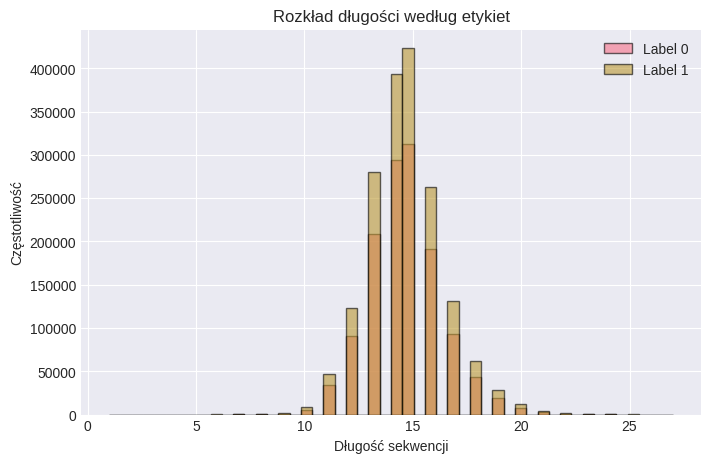

In [12]:
# Analiza długości sekwencji junction_aa
sample_combined['junction_length'] = sample_combined['junction_aa'].str.len()

fig, axes = plt.subplots(1, 1, figsize=(8, 5))

# Rozkład długości według etykiet
for label in [0, 1]:
    label_data = sample_combined[sample_combined['label'] == label]['junction_length']
    axes.hist(label_data.dropna(), bins=50, alpha=0.6, 
                    label=f'Label {label}', edgecolor='black')
axes.set_title('Rozkład długości według etykiet')
axes.set_xlabel('Długość sekwencji')
axes.set_ylabel('Częstotliwość')
axes.legend()


Rozkłady długości dla różnych klas są praktycznie identyczne.

In [13]:
import os
import pandas as pd
import glob
from tqdm import tqdm
# Definiujemy prawidłowe aminokwasy
valid_aa = set('ACDEFGHIKLMNPQRSTVWY')

# Ścieżka do katalogu z danymi
data_dir = '../data'  # lub pełna ścieżka

# Uruchamiamy sprawdzenie wszystkich zbiorów danych
results = validate_sequences_in_datasets(data_dir, valid_aa=valid_aa, sequence_col='junction_aa')

Sprawdzanie zestawów danych train: 8 zestawów


Zestawy train: 100%|██████████| 8/8 [04:20<00:00, 32.60s/it]



Sprawdzanie zestawów danych test: 11 zestawów


Zestawy test: 100%|██████████| 11/11 [03:56<00:00, 21.47s/it]


PODSUMOWANIE SPRAWDZENIA POPRAWNOŚCI SEKWENCJI
Poprawne aminokwasy: ACDEFGHIKLMNPQRSTVWY

ZESTAWY DANYCH TRAIN:
--------------------------------------------------------------------------------
✓ train_dataset_1           | Razem: 10,000,000 | Niepoprawnych:        0 | Poprawność: 100.00% | Plików z błędami:   0
✓ train_dataset_2           | Razem: 10,000,000 | Niepoprawnych:        0 | Poprawność: 100.00% | Plików z błędami:   0
✓ train_dataset_3           | Razem: 10,000,000 | Niepoprawnych:        0 | Poprawność: 100.00% | Plików z błędami:   0
✓ train_dataset_4           | Razem: 10,000,000 | Niepoprawnych:        0 | Poprawność: 100.00% | Plików z błędami:   0
✓ train_dataset_5           | Razem: 10,000,000 | Niepoprawnych:        0 | Poprawność: 100.00% | Plików z błędami:   0
✗ train_dataset_6           | Razem: 10,000,000 | Niepoprawnych:       47 | Poprawność: 100.00% | Plików z błędami:  46
    Plik: ec4501ab4007c7e2c3806db607b80fa1.tsv
      Sekwencja: CSADRGQGEQ*... (niepop

In [14]:
# Sprawdzimy skład aminokwasowy, brak "*", wzorzec cdr3 i długość, a także obecność v_call i j_call

valid_aa_pattern = r'^[ACDEFGHIKLMNPQRSTVWY]+$'
cdr3_pattern = r'^C.*[FW]$'
min_cdr3_length = 8
max_cdr3_length = 25

initial_n = len(sample_combined)

# Filtrowanie: tylko prawidłowe sekwencje według różnych kryteriów
mask_aa = sample_combined['junction_aa'].str.contains(valid_aa_pattern)
mask_stop = ~sample_combined['junction_aa'].str.contains(r'\*')
mask_cdr3 = sample_combined['junction_aa'].str.contains(cdr3_pattern)
mask_len = sample_combined['junction_aa'].str.len().between(min_cdr3_length, max_cdr3_length)

filtered_df = sample_combined[mask_aa & mask_stop & mask_cdr3 & mask_len]
filtered_n = len(filtered_df)

print(f"Początkowo: {initial_n:,}")
print(f"Po filtrowaniu: {filtered_n:,} ({100*filtered_n/initial_n:.1f}%)")

# Zobaczmy ile sekwencji jest odfiltrowywanych według każdego kryterium
print("\nLiczba sekwencji, które NIE przeszły każdego filtra:")
print(f" - Nie przechodzi filtra aminokwasów: {(~mask_aa).sum():,} ({100*(~mask_aa).sum()/initial_n:.1f}%)")
print(f" - Zawiera symbol stop (*): {(~mask_stop).sum():,} ({100*(~mask_stop).sum()/initial_n:.1f}%)")
print(f" - Nie pasuje do wzorca cdr3: {(~mask_cdr3).sum():,} ({100*(~mask_cdr3).sum()/initial_n:.1f}%)")
print(f" - Nie według długości ({min_cdr3_length}-{max_cdr3_length}): {(~mask_len).sum():,} ({100*(~mask_len).sum()/initial_n:.1f}%)")

# Można zobaczyć nakładanie się, jeśli potrzeba bardziej szczegółowo według typów filtra
import pandas as pd
mask_df = pd.DataFrame({'aa': mask_aa, 'stop': mask_stop, 'cdr3': mask_cdr3, 'len': mask_len})
print("\nLiczba przeszłych tylko według każdego kryterium (tylko według tego jednego):")
for col in mask_df.columns:
    only_this = (mask_df[col] & ~mask_df.drop(col, axis=1).any(axis=1)).sum()
    print(f" - Tylko {col}: {only_this:,} ({100*only_this/initial_n:.2f}%)")


Początkowo: 3,088,786
Po filtrowaniu: 3,067,695 (99.3%)

Liczba sekwencji, które NIE przeszły każdego filtra:
 - Nie przechodzi filtra aminokwasów: 0 (0.0%)
 - Zawiera symbol stop (*): 0 (0.0%)
 - Nie pasuje do wzorca cdr3: 20,414 (0.7%)
 - Nie według długości (8-25): 1,135 (0.0%)

Liczba przeszłych tylko według każdego kryterium (tylko według tego jednego):
 - Tylko aa: 0 (0.00%)
 - Tylko stop: 0 (0.00%)
 - Tylko cdr3: 0 (0.00%)
 - Tylko len: 0 (0.00%)


W sekwencji powinny być tylko aminokwasy (20 typów), początek - C (cysteina, zakończenie v_call), koniec - F lub W (początek j_call). '*' oznacza przedwczesny kodon stop, czyli białko będzie prawdopodobnie niefunkcjonalne. Długość: minimalna biologicznie funkcjonalna długość CDR3 = 8, mniejsza długość nie pozwala białku podczas zwijania uformować funkcjonalnej pętli wiążącej antygen, bardzo długie CDR3 - zbyt elastyczne i niestabilne.

#### Analiza v_call (geny V)

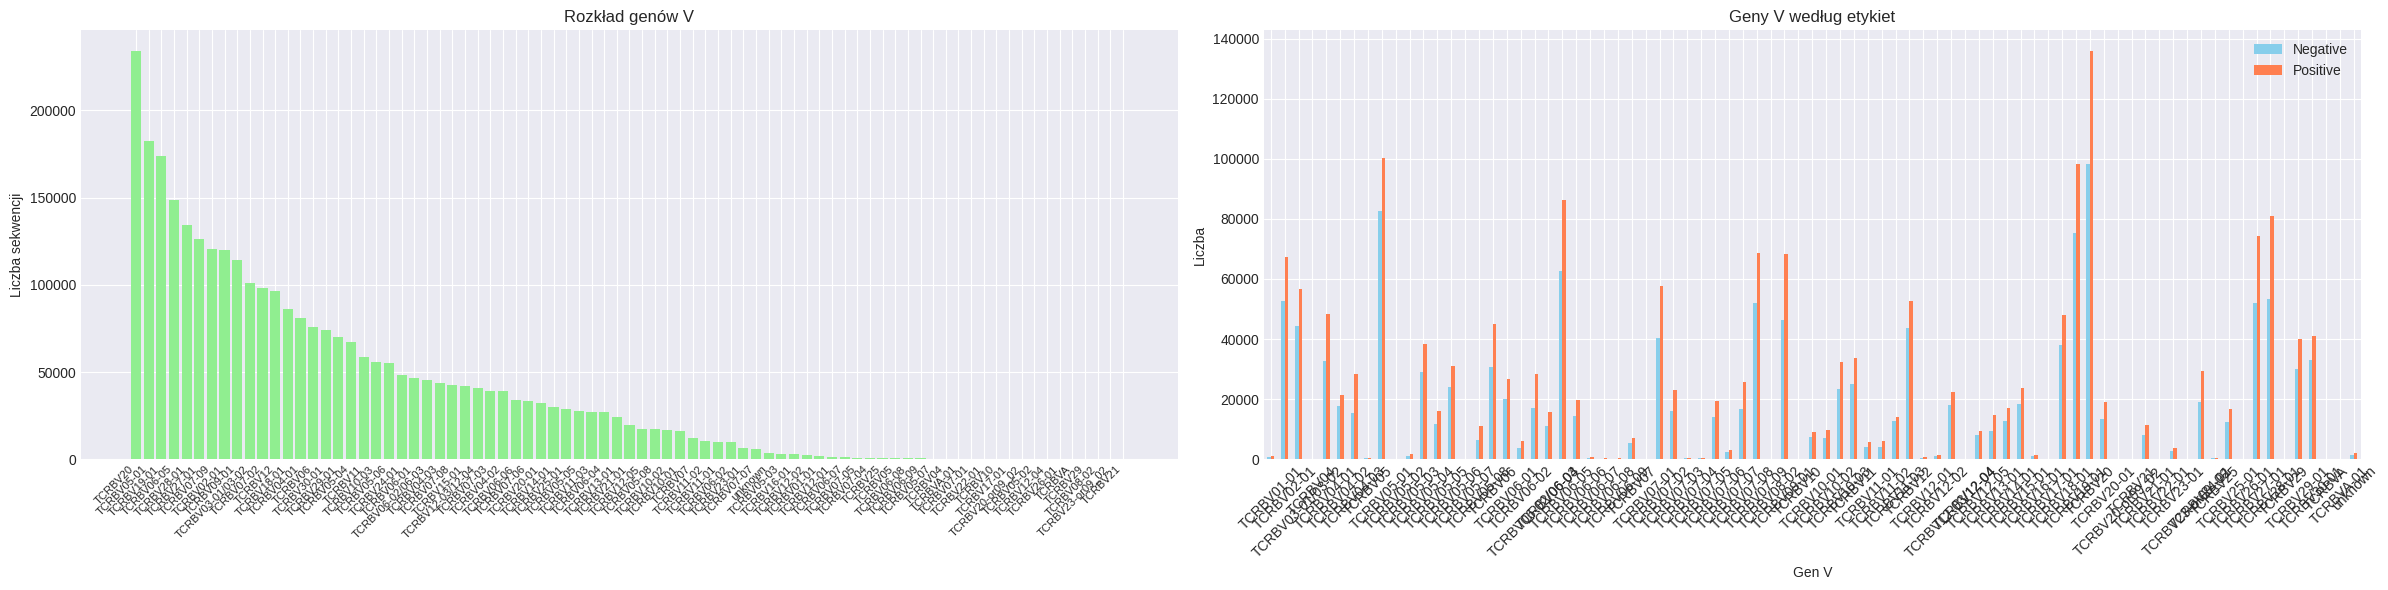

In [15]:
v_call_counts = sample_combined['v_call'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(24, 6))

# Rozkład genów V
axes[0].bar(range(len(v_call_counts)), v_call_counts.values, color='lightgreen')
axes[0].set_xticks(range(len(v_call_counts)))
axes[0].set_xticklabels(v_call_counts.index, rotation=45, ha='right', fontsize=8)
axes[0].set_title('Rozkład genów V')
axes[0].set_ylabel('Liczba sekwencji')

# Rozkład genów V według etykiet
v_by_label = pd.crosstab(sample_combined['v_call'], sample_combined['label'])
v_by_label.plot(kind='bar', ax=axes[1], color=['skyblue', 'coral'])
axes[1].set_title('Geny V według etykiet')
axes[1].set_xlabel('Gen V')
axes[1].set_ylabel('Liczba')
axes[1].legend(['Negative', 'Positive'])
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### Analiza j_call (geny J)

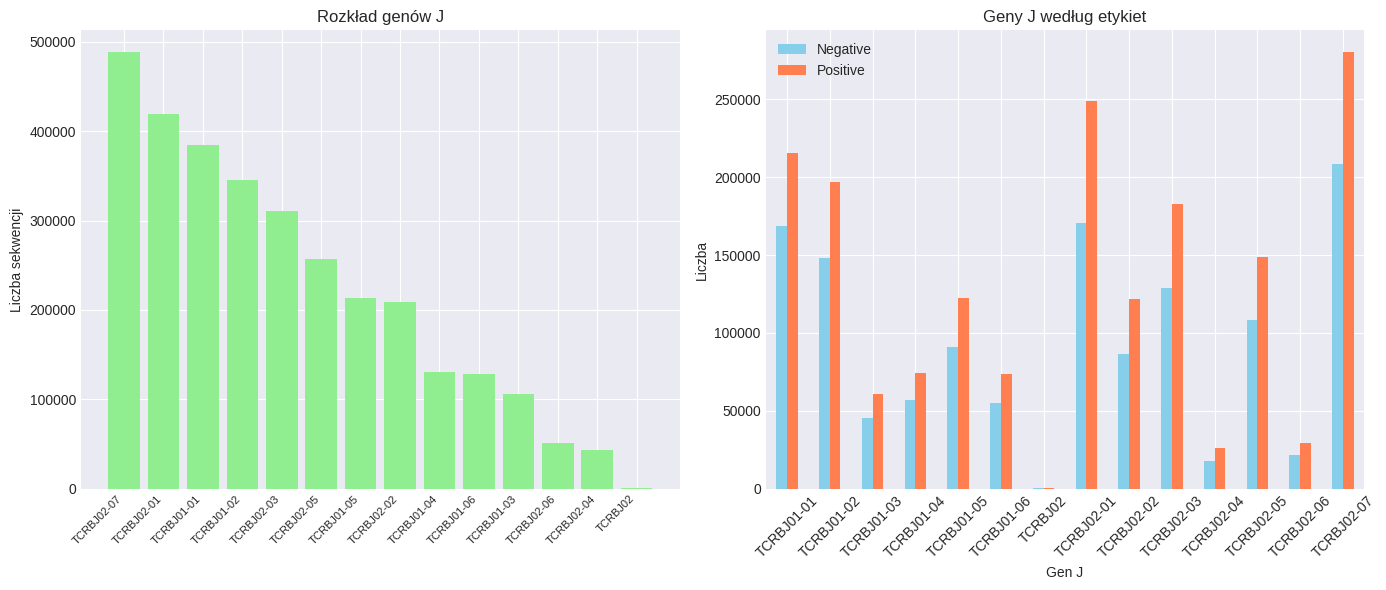

In [16]:
j_call_counts = sample_combined['j_call'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Rozkład genów J
axes[0].bar(range(len(j_call_counts)), j_call_counts.values, color='lightgreen')
axes[0].set_xticks(range(len(j_call_counts)))
axes[0].set_xticklabels(j_call_counts.index, rotation=45, ha='right', fontsize=8)
axes[0].set_title('Rozkład genów J')
axes[0].set_ylabel('Liczba sekwencji')

# Rozkład genów J według etykiet
j_by_label = pd.crosstab(sample_combined['j_call'], sample_combined['label'])
j_by_label.plot(kind='bar', ax=axes[1], color=['skyblue', 'coral'])
axes[1].set_title('Geny J według etykiet')
axes[1].set_xlabel('Gen J')
axes[1].set_ylabel('Liczba')
axes[1].legend(['Negative', 'Positive'])
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### Analiza d_call (geny D) jeśli występuje

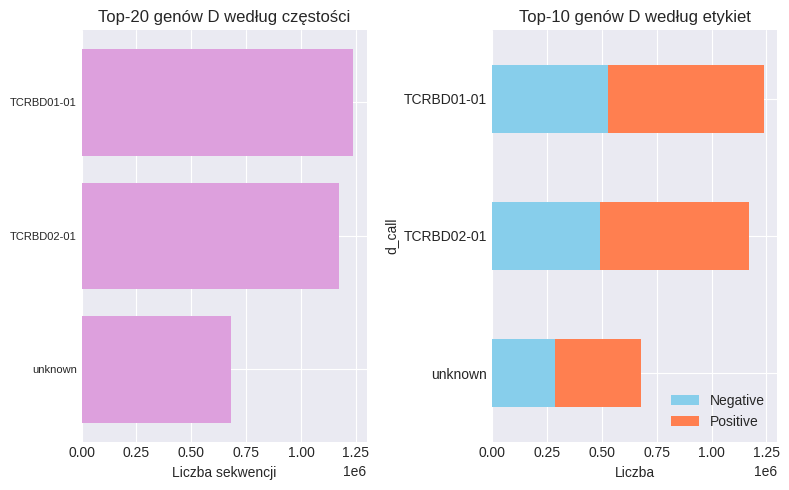

In [17]:

if 'd_call' in sample_combined.columns:
    d_call_counts = sample_combined['d_call'].value_counts().head(20)
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 5))
    
    # Top-20 genów D
    axes[0].barh(range(len(d_call_counts)), d_call_counts.values, color='plum')
    axes[0].set_yticks(range(len(d_call_counts)))
    axes[0].set_yticklabels(d_call_counts.index, fontsize=8)
    axes[0].set_title('Top-20 genów D według częstości')
    axes[0].set_xlabel('Liczba sekwencji')
    axes[0].invert_yaxis()
    
    # Rozkład według etykiet (top-10)
    top_d_genes = d_call_counts.head(10).index
    d_by_label = pd.crosstab(sample_combined['d_call'], sample_combined['label'])
    d_by_label_top = d_by_label.loc[d_by_label.index.isin(top_d_genes)]
    d_by_label_top.plot(kind='barh', stacked=True, ax=axes[1], color=['skyblue', 'coral'])
    axes[1].set_title('Top-10 genów D według etykiet')
    axes[1].set_xlabel('Liczba')
    axes[1].legend(['Negative', 'Positive'])
    axes[1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
else:
    print("Geny D (d_call) nie zostały znalezione w danych")

Dla 30 pacjentów widzimy, że jest duża różnorodność w v_call, średnia - w j_call i prawie brak wariacji w d_call.

#### Analiza templates (liczba kopii sekwencji)

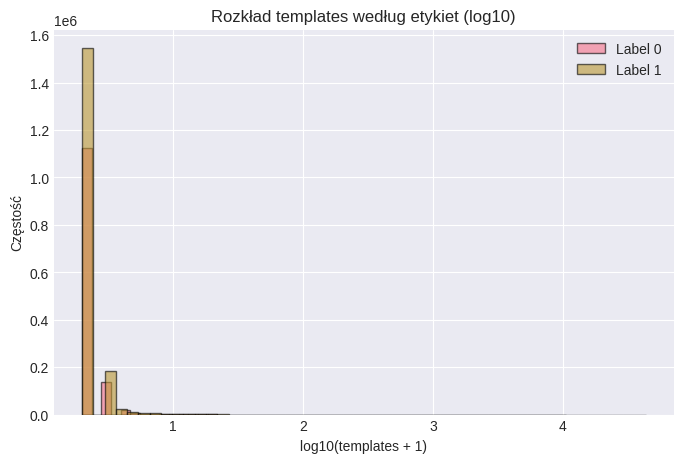

In [18]:

if 'templates' in sample_combined.columns:
    sample_combined['templates'] = pd.to_numeric(sample_combined['templates'], errors='coerce')
    
    fig, axes = plt.subplots(1, 1, figsize=(8, 5))
    
    # Rozkład według etykiet
    for label in [0, 1]:
        label_data = sample_combined[sample_combined['label'] == label]['templates']
        axes.hist(np.log10(label_data.dropna() + 1), bins=50, alpha=0.6, 
                       label=f'Label {label}', edgecolor='black')
    axes.set_title('Rozkład templates według etykiet (log10)')
    axes.set_xlabel('log10(templates + 1)')
    axes.set_ylabel('Częstość')
    axes.legend()
    
else:
    print("Templates nie zostały znalezione w danych")

Widać, że większość sekwencji ma niewiele klonów, ale są silnie wyróżniające się z bardzo dużą liczbą klonów.

# EDA: Analiza k-mers (k=3)

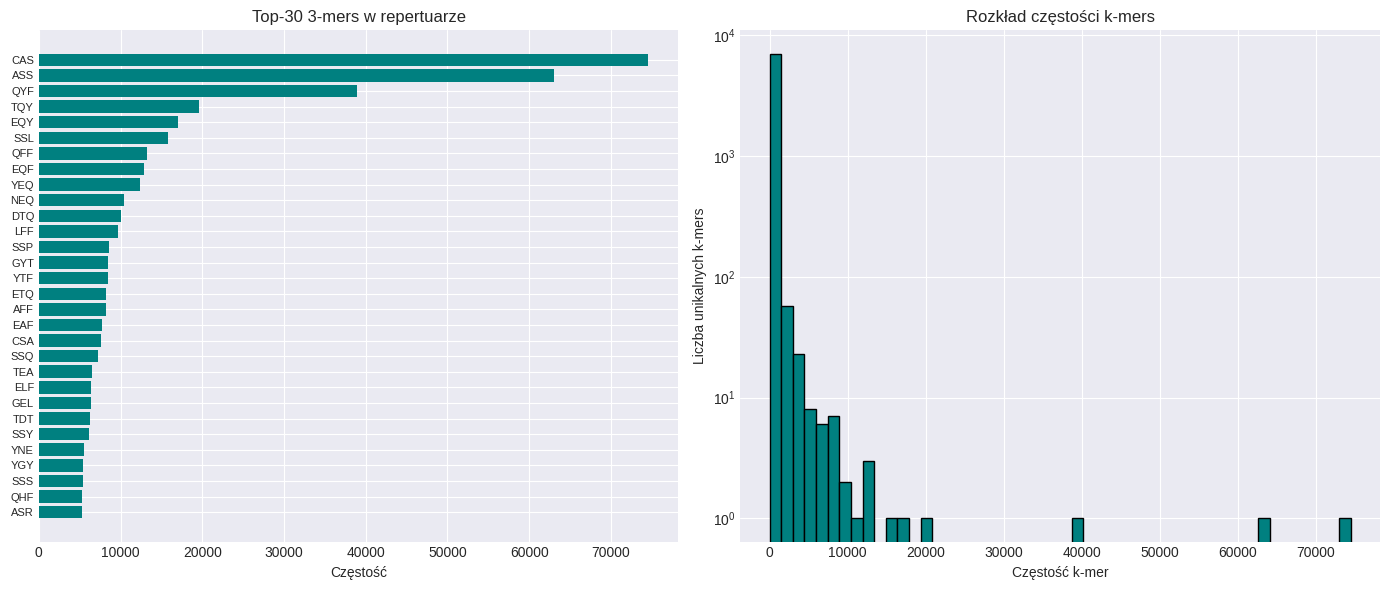


Łącznie unikalnych 3-mers w repertuarze: 7147

Top-10 3-mers:
  CAS: 74540
  ASS: 62988
  QYF: 38888
  TQY: 19613
  EQY: 16984
  SSL: 15813
  QFF: 13246
  EQF: 12911
  YEQ: 12371
  NEQ: 10458


In [19]:
# Funkcja do wyodrębniania k-mers
def extract_kmers(sequence, k=3):
    """Wyodrębnia wszystkie k-mers z sekwencji"""
    if pd.isna(sequence) or len(sequence) < k:
        return []
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

# Analiza k-mers na przykładzie jednego repertuaru
sample_repertoire = sample_combined[sample_combined['repertoire_id'] == sample_combined['repertoire_id'].iloc[0]]

# Wyodrębniamy wszystkie 3-mers
all_kmers = []
for seq in sample_repertoire['junction_aa'].dropna():
    all_kmers.extend(extract_kmers(seq, k=3))

kmer_counts = Counter(all_kmers)
top_kmers = dict(kmer_counts.most_common(30))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Top-30 k-mers
axes[0].barh(range(len(top_kmers)), list(top_kmers.values()), color='teal')
axes[0].set_yticks(range(len(top_kmers)))
axes[0].set_yticklabels(list(top_kmers.keys()), fontsize=8)
axes[0].set_title('Top-30 3-mers w repertuarze')
axes[0].set_xlabel('Częstość')
axes[0].invert_yaxis()

# Rozkład częstości k-mers
kmer_freqs = list(kmer_counts.values())
axes[1].hist(kmer_freqs, bins=50, color='teal', edgecolor='black')
axes[1].set_title('Rozkład częstości k-mers')
axes[1].set_xlabel('Częstość k-mer')
axes[1].set_ylabel('Liczba unikalnych k-mers')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

print(f"\nŁącznie unikalnych 3-mers w repertuarze: {len(kmer_counts)}")
print(f"\nTop-10 3-mers:")
for kmer, count in list(kmer_counts.most_common(10)):
    print(f"  {kmer}: {count}")

CDR3 z definicji zaczyna się od konserwatywnej cysteiny (C) na końcu segmentu V. CASS - super częsty start, występuje w ~30-40% wszystkich sekwencji.

CDR3 kończy się konserwatywnym F (fenyloalaniną) lub W (tryptofanem) z segmentu J. TQYF - to wzorzec z segmentu J TCRBJ02-03 (jeden z najpopularniejszych).

Cechy częstości, na przykład, segmentu J TCRBJ02-03 i wzorca TQYF będą skorelowane.

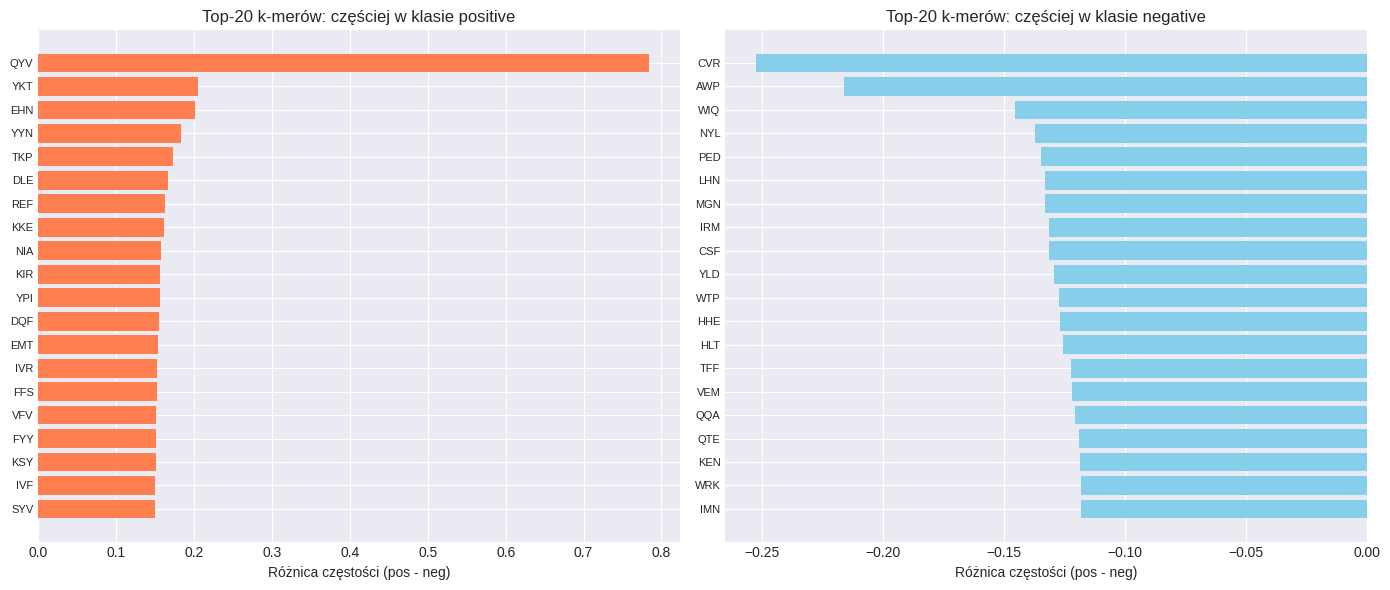


=== TOP-10 K-MERÓW Z NAJWIĘKSZĄ RÓŻNICĄ (na korzyść positive) ===
  kmer  pos_freq  neg_freq  difference
0  QYV  0.000556  0.000112    0.784008
1  YKT  0.000010  0.000006    0.205152
2  EHN  0.000014  0.000009    0.201173
3  YYN  0.000094  0.000075    0.183044
4  TKP  0.000017  0.000013    0.172432
5  DLE  0.000051  0.000041    0.166467
6  REF  0.000044  0.000035    0.162091
7  KKE  0.000012  0.000008    0.161695
8  NIA  0.000011  0.000007    0.158010
9  KIR  0.000010  0.000007    0.156184


In [20]:
# Porównanie k-merów między klasami positive i negative
positive_kmers = []
negative_kmers = []

for label in [0, 1]:
    label_data = sample_combined[sample_combined['label'] == label]['junction_aa']
    for seq in label_data.dropna():
        kmers = extract_kmers(seq, k=3)
        if label == 1:
            positive_kmers.extend(kmers)
        else:
            negative_kmers.extend(kmers)

pos_kmer_counts = Counter(positive_kmers)
neg_kmer_counts = Counter(negative_kmers)

# Znajdujemy k-mery, które częściej występują w klasie positive
all_unique_kmers = set(list(pos_kmer_counts.keys()) + list(neg_kmer_counts.keys()))
kmer_differences = []

for kmer in all_unique_kmers:
    pos_freq = pos_kmer_counts.get(kmer, 0) / len(positive_kmers) if positive_kmers else 0
    neg_freq = neg_kmer_counts.get(kmer, 0) / len(negative_kmers) if negative_kmers else 0
    diff = (pos_freq - neg_freq) / (pos_freq + 1e-5)
    kmer_differences.append((kmer, pos_freq, neg_freq, diff))

kmer_diff_df = pd.DataFrame(kmer_differences, 
                            columns=['kmer', 'pos_freq', 'neg_freq', 'difference'])
kmer_diff_df = kmer_diff_df.sort_values('difference', ascending=False)

# Wizualizacja
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Top-20 k-merów z największą różnicą na korzyść positive
top_diff = kmer_diff_df.head(20)
axes[0].barh(range(len(top_diff)), top_diff['difference'].values, color='coral')
axes[0].set_yticks(range(len(top_diff)))
axes[0].set_yticklabels(top_diff['kmer'].values, fontsize=8)
axes[0].set_title('Top-20 k-merów: częściej w klasie positive')
axes[0].set_xlabel('Różnica częstości (pos - neg)')
axes[0].invert_yaxis()

# Top-20 k-merów z największą różnicą na korzyść negative
bottom_diff = kmer_diff_df.tail(20).sort_values('difference')
axes[1].barh(range(len(bottom_diff)), bottom_diff['difference'].values, color='skyblue')
axes[1].set_yticks(range(len(bottom_diff)))
axes[1].set_yticklabels(bottom_diff['kmer'].values, fontsize=8)
axes[1].set_title('Top-20 k-merów: częściej w klasie negative')
axes[1].set_xlabel('Różnica częstości (pos - neg)')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\n=== TOP-10 K-MERÓW Z NAJWIĘKSZĄ RÓŻNICĄ (na korzyść positive) ===")
print(kmer_diff_df.head(10)[['kmer', 'pos_freq', 'neg_freq', 'difference']].reset_index(drop=True))

Wykorzystanie k-merów jako cech - jedno z klasycznych podejść (N. Thomas, K. Best, M. Cinelli, S. Reich-Zeliger, H. Gal, E. Shifrut, A. Madi, N. Friedman, J. Shawe-Taylor, B. Chain. Tracking global changes induced in the CD4 T cell receptor repertoire by immunization with a complex antigen using short stretches of CDR3 protein sequence
Bioinformatics (2014), 10.1093/bioinformatics/btu523).

# EDA: Porównanie cech między zbiorami danych

/tmp/ipykernel_40914/1170133299.py:28: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/tmp/ipykernel_40914/1170133299.py:28: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/tmp/ipykernel_40914/1170133299.py:28: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



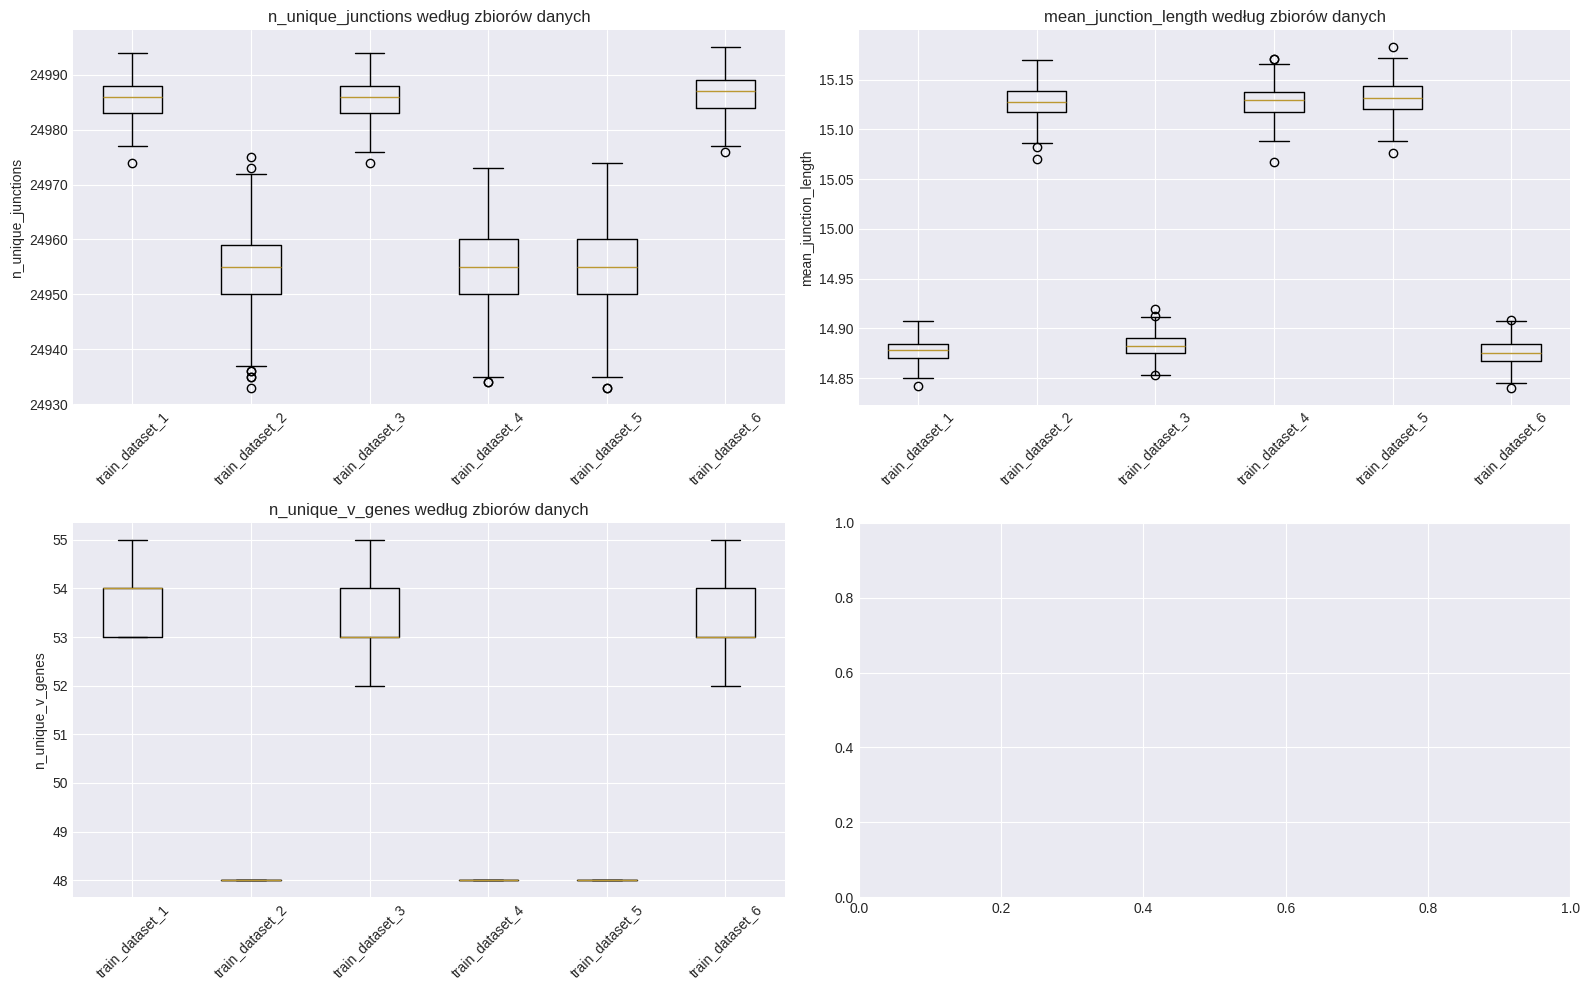


=== ŚREDNIE WARTOŚCI CECH WEDŁUG ZBIORÓW DANYCH ===
                 n_unique_junctions  mean_junction_length  n_unique_v_genes
dataset                                                                    
train_dataset_1            24985.46                 14.88             53.78
train_dataset_2            24954.73                 15.13             48.00
train_dataset_3            24985.83                 14.88             53.41
train_dataset_4            24955.02                 15.13             48.00
train_dataset_5            24954.60                 15.13             48.00
train_dataset_6            24986.51                 14.88             53.40


In [22]:
# Porównanie cech repertuaru między zbiorami danych
# Obliczamy cechy dla kilku zbiorów danych
all_repertoire_features = []

for train_ds in train_datasets[:6]:  # Analizujemy pierwsze 4 zbiory danych dla szybkości
    metadata = pd.read_csv(train_ds / 'metadata.csv')
    metadata['dataset'] = train_ds.name
    features = compute_repertoire_features(metadata, train_ds)
    all_repertoire_features.append(features)

repertoire_features_all = pd.concat(all_repertoire_features, ignore_index=True)

# Wizualizacja porównania zbiorów danych
key_features = ['n_unique_junctions', 'mean_junction_length', 'n_unique_v_genes']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, feature in enumerate(key_features):
    if feature in repertoire_features_all.columns:
        data_to_plot = []
        labels_to_plot = []
        for dataset in repertoire_features_all['dataset'].unique():
            dataset_data = repertoire_features_all[repertoire_features_all['dataset'] == dataset][feature].dropna()
            data_to_plot.append(dataset_data.values)
            labels_to_plot.append(dataset)
        
        axes[idx].boxplot(data_to_plot, labels=labels_to_plot)
        axes[idx].set_title(f'{feature} według zbiorów danych')
        axes[idx].set_ylabel(feature)
        axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n=== ŚREDNIE WARTOŚCI CECH WEDŁUG ZBIORÓW DANYCH ===")
print(repertoire_features_all.groupby('dataset')[key_features].mean().round(2))

Różnice między pierwszymi 6 zbiorami danych są praktycznie niewidoczne. W komentarzach do konkursu wskazano, że są to syntetycznie utworzone zbiory danych.

# Wnioski i rekomendacje

In [2]:
print("=== KLUCZOWE WNIOSKI Z EDA ===\n")

print("1. METADANE:")
print("   - Rozkład etykiet różni się między zbiorami danych - należy uwzględnić balans klas podczas trenowania modelu\n")

print("2. SEKWENCJE TCR:")
print("   - Długość junction_aa różni się dla rzeczywistych danych (zbiory 7-8)")
print("   - Geny V i geny J mają różne rozkłady")
print("   - Templates pokazują szeroki rozkład (skala logarytmiczna)\n")

print("3. CECHY REPERTUARU:")
print("   - Liczba unikalnych sekwencji różni się między klasami")
print("   - Różnorodność genów V/J może być ważną cechą")
print("   - Statystyki długości sekwencji korelują z etykietą\n")

print("4. K-MERY:")
print("   - Niektóre k-mery częściej występują w klasie positive")
print("   - Częstości k-merów mogą być efektywnymi cechami\n")

print("5. REKOMENDACJE DO MODELOWANIA:")
print("   - Używać kodowania k-merów (k=3, ewentualnie k=4)")
print("   - Agregować cechy na poziomie repertuaru")
print("   - Rozważyć geny V/J jako cechy kategoryczne")
print("   - Używać templates jako wag dla sekwencji")

=== KLUCZOWE WNIOSKI Z EDA ===

1. METADANE:
   - Rozkład etykiet różni się między zbiorami danych - należy uwzględnić balans klas podczas trenowania modelu

2. SEKWENCJE TCR:
   - Długość junction_aa różni się dla rzeczywistych danych (zbiory 7-8)
   - Geny V i geny J mają różne rozkłady
   - Templates pokazują szeroki rozkład (skala logarytmiczna)

3. CECHY REPERTUARU:
   - Liczba unikalnych sekwencji różni się między klasami
   - Różnorodność genów V/J może być ważną cechą
   - Statystyki długości sekwencji korelują z etykietą

4. K-MERY:
   - Niektóre k-mery częściej występują w klasie positive
   - Częstości k-merów mogą być efektywnymi cechami

5. REKOMENDACJE DO MODELOWANIA:
   - Używać kodowania k-merów (k=3, ewentualnie k=4)
   - Agregować cechy na poziomie repertuaru
   - Rozważyć geny V/J jako cechy kategoryczne
   - Używać templates jako wag dla sekwencji


# Trening

- **Model**: regresja logistyczna lub CatBoost
- **Ważność cech**: feature_importances modelu lub SHAP
- **Cechy**: częstości 3k-mer/4k-mer (i opcjonalnie v_call, j_call, d_call)
- **Wagi sekwencji**: jednostkowe liczenie częstości lub uwzględnienie templates (kopie klonalne)
- **Dokładny Test Fishera**: dla każdej sekwencji (v+cdr3+j)
- **Cechy Burden**: dla każdego testu

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Importujemy wszystkie funkcje i klasy z utils
from utils import (
    # Funkcje ładowania danych
    save_tsv, concatenate_output_files, save_metrics,
    
    # Predictors (klasy wysokiego poziomu)
    KmerImmuneStatePredictor,  # Dla modeli k-mer
    FisherBurdenImmuneStatePredictor,  # Dla podejścia Fisher + Burden
    
)

Plotly initialized for interactive plots


Dla konkursu zostały uruchomione i porównane modele na wszystkich danych. W ramach projektu zrobimy próbkę z dużych plików (zbiór danych 7 i zbiór danych 8). Pełny zbiór danych podczas przetwarzania zajmuje do 30 GB pamięci operacyjnej.

In [ ]:
metadata_7_path = '../data/train_datasets/train_dataset_7/metadata.csv'
metadata_7_df = pd.read_csv(metadata_7_path)

metadata_7_df['stratify_group'] = (
    metadata_7_df['label_positive'].astype(str) + '_' +
    metadata_7_df['sequencing_run_id'].astype(str) + '_' +
    metadata_7_df['sex'].astype(str)
)

# Sprawdzamy rozkład
print("Rozkład grup do stratyfikacji:")
print(metadata_7_df['stratify_group'].value_counts())

# Podział train/val jest wewnątrz FisherBurdenImmuneStatePredictor.fit() — nie nadpisujemy metadata.csv

Rozkład grup do stratyfikacji:
stratify_group
False_batch_2_female    65
False_batch_1_female    60
False_batch_1_male      36
False_batch_3_female    33
False_batch_3_male      29
False_batch_2_male      29
True_batch_1_female     16
True_batch_2_female     15
True_batch_3_female      8
True_batch_1_male        5
True_batch_3_male        3
True_batch_2_male        3
Name: count, dtype: int64


In [ ]:
metadata_8_path = '../data/train_datasets/train_dataset_8/metadata.csv'
metadata_8_df = pd.read_csv(metadata_8_path).dropna(subset=['sex'])

metadata_8_df['stratify_group'] = (
    metadata_8_df['label_positive'].astype(str) + '_' +
    metadata_8_df['study_group_description'].astype(str) + '_' +
    metadata_8_df['sex'].astype(str)
)

# Sprawdzamy rozkład
print("Rozkład grup do stratyfikacji:")
print(metadata_8_df['stratify_group'].value_counts())

_, new_metadata_8_df = train_test_split(metadata_8_df, test_size=0.2, random_state=42, stratify=metadata_8_df['stratify_group'], shuffle=True)
new_metadata_8_df.drop(columns=['stratify_group']).to_csv(metadata_8_path, index=False)

Rozkład grup do stratyfikacji:
stratify_group
False_FDR_F     258
False_FDR_M     174
True_T1D_F      151
True_T1D_M      147
False_CTRL_F     84
False_CTRL_M     47
False_SDR_F      34
False_SDR_M      12
Name: count, dtype: int64


## Dobór modelu i cech

W tym konkursie na Kaggle private score był liczony na 99% danych testowych i na średniej ważonej dwóch metryk (prawidłowo wybrane ważne sekwencje i prawidłowa predykcja binarna), podczas gdy public score był liczony na podstawie 1% danych testowych i tylko na prawidłową predykcję binarną.

Wyniki eksperymentów

1. [Eksperyment 1: Baseline (3-mer)](#exp1)
2. [Eksperyment 2: Dodanie templates](#exp2)
3. [Eksperyment 3: Dodanie genów V/J](#exp3)
4. [Eksperyment 4: CatBoost](#exp4)
5. [Eksperyment 5: SHAP (3-mer)](#exp5)
6. [Eksperyment 6: 4-mer + SHAP](#exp6)
7. [Eksperyment 7: Test Fishera + Cechy Burden](#exp7)

<a id="exp1"></a>
### Eksperyment 1: Baseline (3-mer bez genów V/J, bez templates)

**Konfiguracja:**
- Cechy: częstości 3-merów w sekwencjach CDR3
- Model: regresja logistyczna z regularyzacją L1
- Ważność sekwencji: feature importance z modelu

In [ ]:
# ===========================================================================================
# 1: 3k-mer + bez cech vj + bez templates + regresja logistyczna + ważność cech modelu
# ===========================================================================================

# Metryki Kaggle
# Wynik prywatny: 0.43204
# Wynik publiczny: 0.62136

train_datasets_dir = "../data/train_datasets"
test_datasets_dir = "../data/test_datasets"
results_dir = '../results_3kmer_no_vj_no_templates_lr_model_importance'

# Pobieramy wszystkie foldery-zbiory danych train/test
train_dirs = sorted([os.path.join(train_datasets_dir, d) for d in os.listdir(train_datasets_dir) if os.path.isdir(os.path.join(train_datasets_dir, d))])
test_dirs = sorted([os.path.join(test_datasets_dir, d) for d in os.listdir(test_datasets_dir) if os.path.isdir(os.path.join(test_datasets_dir, d))])

# Iteracja po folderach-zbiorach danych (po parach train/test lub po train przy pojedynczej analizie)
for train_dir, test_dir in zip(train_dirs, test_dirs):
    dataset_name = os.path.basename(train_dir)
    print(f"\n=== Praca nad zbiorem danych: {dataset_name} ===\n")

    # Tworzymy predictor
    predictor = KmerImmuneStatePredictor(
        k=3,
        use_templates=False,
        include_vj_features=False,
        model_type='logistic_regression',
        importance_method='model_importance',
        min_count=1,
        c_values=[1, 0.1, 0.05, 0.03],
        cv_folds=5,
        opt_metric='roc_auc',
        random_state=123,
        n_jobs=-1
    )

    # Trenowanie
    predictor.fit(train_dir_path=train_dir)

    # Zapisywanie metryk
    config_params = {
        'k': predictor.k,
        'use_templates': predictor.use_templates,
        'include_vj_features': predictor.include_vj_features,
        'model_type': predictor.model_type,
        'importance_method': predictor.importance_method,
        'min_count': predictor.min_count,
        'cv_folds': predictor.cv_folds,
        'opt_metric': predictor.opt_metric
    }
    save_metrics(predictor, dataset_name, results_dir, config_params)

    # Przewidywanie
    predictions_df = predictor.predict_proba(test_dir_path=test_dir, results_dir=results_dir)

    # Identyfikacja ważnych sekwencji
    important_seqs = predictor.identify_associated_sequences(train_dir_path=train_dir, top_k=50000)

    # Zapisywanie wyników za pomocą save_tsv (jak w _save_predictions i _save_important_sequences)
    preds_path = os.path.join(results_dir, f"{dataset_name}_test_predictions.tsv")
    save_tsv(predictions_df, preds_path)
    print(f"Przewidywania zapisane do `{preds_path}`")
    
    seqs_path = os.path.join(results_dir, f"{dataset_name}_important_sequences.tsv")
    save_tsv(important_seqs, seqs_path)
    print(f"Ważne sekwencje zapisane do `{seqs_path}`")

# Łączymy wszystkie wyniki na końcu
print("Łączenie plików wyjściowych...")
concatenate_output_files(results_dir)
print("Wszystko gotowe!")




=== Praca nad zbiorem danych: train_dataset_1 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów: 100%|██████████| 400/400 [01:00<00:00,  6.66it/s]


Wyrównano 400 próbek z etykietami
Najlepsze C: 0.05 (CV roc_auc: 0.5707 ± 0.0431)
Walidacja roc_auc: 0.5381
Walidacja MCC: 0.0750
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 7672608/7672608 [00:23<00:00, 331224.78it/s]
Metryki zapisane do `../results_3kmer_no_vj_no_templates_lr_model_importance/metrics.csv`
Kodowanie 3-merów: 100%|██████████| 400/400 [01:05<00:00,  6.08it/s]


Przewidywanie zakończone na 400 przykładach.


Ocenianie sekwencji: 100%|██████████| 7672608/7672608 [00:23<00:00, 327411.10it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_no_templates_lr_model_importance/train_dataset_1_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_no_templates_lr_model_importance/train_dataset_1_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_2 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów: 100%|██████████| 400/400 [01:07<00:00,  5.94it/s]


Wyrównano 400 próbek z etykietami
Najlepsze C: 0.03 (CV roc_auc: 0.4674 ± 0.0520)
Uwaga: Przewidywania zostaną odwrócone (wykryto AUC < 0.5)
Walidacja roc_auc: 0.4375
Walidacja MCC: -0.1091
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 9693967/9693967 [00:30<00:00, 318976.01it/s]
Metryki zapisane do `../results_3kmer_no_vj_no_templates_lr_model_importance/metrics.csv`
Kodowanie 3-merów: 100%|██████████| 400/400 [01:06<00:00,  5.97it/s]


Przewidywanie zakończone na 400 przykładach.


Ocenianie sekwencji: 100%|██████████| 9693967/9693967 [00:30<00:00, 322462.77it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_no_templates_lr_model_importance/train_dataset_2_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_no_templates_lr_model_importance/train_dataset_2_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_3 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów: 100%|██████████| 400/400 [01:05<00:00,  6.08it/s]


Wyrównano 400 próbek z etykietami
Najlepsze C: 0.1 (CV roc_auc: 0.5455 ± 0.0488)
Walidacja roc_auc: 0.5919
Walidacja MCC: 0.1001
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 7677838/7677838 [00:23<00:00, 333198.49it/s]
Metryki zapisane do `../results_3kmer_no_vj_no_templates_lr_model_importance/metrics.csv`
Kodowanie 3-merów: 100%|██████████| 400/400 [01:08<00:00,  5.86it/s]


Przewidywanie zakończone na 400 przykładach.


Ocenianie sekwencji: 100%|██████████| 7677838/7677838 [00:24<00:00, 314652.67it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_no_templates_lr_model_importance/train_dataset_3_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_no_templates_lr_model_importance/train_dataset_3_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_4 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów: 100%|██████████| 400/400 [01:09<00:00,  5.72it/s]


Wyrównano 400 próbek z etykietami
Najlepsze C: 0.05 (CV roc_auc: 0.5660 ± 0.0450)
Walidacja roc_auc: 0.6700
Walidacja MCC: 0.2003
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 9695072/9695072 [00:32<00:00, 301399.38it/s]
Metryki zapisane do `../results_3kmer_no_vj_no_templates_lr_model_importance/metrics.csv`
Kodowanie 3-merów: 100%|██████████| 400/400 [01:09<00:00,  5.75it/s]


Przewidywanie zakończone na 400 przykładach.


Ocenianie sekwencji: 100%|██████████| 9695072/9695072 [00:30<00:00, 315759.35it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_no_templates_lr_model_importance/train_dataset_4_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_no_templates_lr_model_importance/train_dataset_4_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_5 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów: 100%|██████████| 400/400 [01:07<00:00,  5.90it/s]


Wyrównano 400 próbek z etykietami
Najlepsze C: 1.0 (CV roc_auc: 0.9598 ± 0.0187)
Walidacja roc_auc: 0.9725
Walidacja MCC: 0.7752
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 9695773/9695773 [00:30<00:00, 319686.57it/s]
Metryki zapisane do `../results_3kmer_no_vj_no_templates_lr_model_importance/metrics.csv`
Kodowanie 3-merów: 100%|██████████| 400/400 [01:07<00:00,  5.96it/s]


Przewidywanie zakończone na 400 przykładach.


Ocenianie sekwencji: 100%|██████████| 9695773/9695773 [00:31<00:00, 311008.40it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_no_templates_lr_model_importance/train_dataset_5_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_no_templates_lr_model_importance/train_dataset_5_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_6 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów: 100%|██████████| 400/400 [01:07<00:00,  5.96it/s]


Wyrównano 400 próbek z etykietami
Najlepsze C: 0.03 (CV roc_auc: 0.6880 ± 0.0543)
Walidacja roc_auc: 0.7609
Walidacja MCC: 0.4005
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 7667869/7667869 [00:23<00:00, 325819.27it/s]
Metryki zapisane do `../results_3kmer_no_vj_no_templates_lr_model_importance/metrics.csv`
Kodowanie 3-merów: 100%|██████████| 400/400 [01:07<00:00,  5.92it/s]


Przewidywanie zakończone na 400 przykładach.


Ocenianie sekwencji: 100%|██████████| 7667869/7667869 [00:23<00:00, 321774.69it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_no_templates_lr_model_importance/train_dataset_6_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_no_templates_lr_model_importance/train_dataset_6_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_7 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów:  30%|███       | 91/302 [01:04<02:29,  1.41it/s]


Wyrównano 91 próbek z etykietami
Najlepsze C: 1.0 (CV roc_auc: 0.3007 ± 0.1938)
Uwaga: Przewidywania zostaną odwrócone (wykryto AUC < 0.5)
Walidacja roc_auc: 0.8542
Walidacja MCC: 0.1021
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 23213227/23213227 [00:41<00:00, 554097.35it/s]
Metryki zapisane do `../results_3kmer_no_vj_no_templates_lr_model_importance/metrics.csv`
Kodowanie 3-merów: 100%|██████████| 76/76 [00:54<00:00,  1.39it/s]


Przewidywanie zakończone na 76 przykładach.


Ocenianie sekwencji: 100%|██████████| 23213227/23213227 [00:44<00:00, 517920.76it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_no_templates_lr_model_importance/train_dataset_7_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_no_templates_lr_model_importance/train_dataset_7_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_8 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów:  20%|██        | 182/908 [00:44<02:55,  4.13it/s]


Wyrównano 182 próbek z etykietami
Najlepsze C: 0.05 (CV roc_auc: 0.5755 ± 0.1019)
Walidacja roc_auc: 0.5067
Walidacja MCC: 0.0261
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 16042449/16042449 [00:29<00:00, 551039.48it/s]
Metryki zapisane do `../results_3kmer_no_vj_no_templates_lr_model_importance/metrics.csv`
Kodowanie 3-merów: 100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


Przewidywanie zakończone na 100 przykładach.


Ocenianie sekwencji: 100%|██████████| 16042449/16042449 [00:27<00:00, 574619.09it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_no_templates_lr_model_importance/train_dataset_8_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_no_templates_lr_model_importance/train_dataset_8_important_sequences.tsv`
Łączenie plików wyjściowych...
Połączone dane wyjściowe zapisane do `../results_3kmer_no_vj_no_templates_lr_model_importance/submissions.csv`.
Wszystko gotowe!


**Wyniki:**
- Zbiór danych 1: CV AUC = 0.57, Val AUC = 0.54 (blisko losowego)
- Zbiór danych 2: CV AUC = 0.47, Val AUC = 0.44 (inwersja przewidywań)
- Zbiór danych 3: CV AUC = 0.55, Val AUC = 0.59 (minimalna poprawa)
- Zbiór danych 4: CV AUC = 0.57, Val AUC = 0.67
- Zbiór danych 5: CV AUC = 0.96, Val AUC = 0.97 (doskonały wynik)
- Zbiór danych 6: CV AUC = 0.69, Val AUC = 0.76 (dobrze)
- Zbiór danych 7: CV AUC = 0.30, Val AUC = 0.85 (inwersja, mała próbka)
- Zbiór danych 8: CV AUC = 0.58, Val AUC = 0.51

**Wniosek:** Metoda działa dobrze tylko na zbiorze danych 5. Dla pozostałych wymagane są ulepszenia.

<a id="exp2"></a>
### Eksperyment 2: Dodanie templates (kopii klonalnych)

**Zmiany:** Uwzględnienie liczby kopii każdej sekwencji (templates)

In [ ]:
# ===========================================================================================
# 2: 3k-mer + bez cech vj + użycie templates + regresja logistyczna + ważność cech modelu
# ===========================================================================================

# Metryki Kaggle
# Wynik prywatny: 0.43204
# Wynik publiczny: 0.62136

results_dir = '../results_3kmer_no_vj_templates_lr_model_importance'

# Pobieramy wszystkie foldery-zbiory danych train/test
train_dirs = sorted([os.path.join(train_datasets_dir, d) for d in os.listdir(train_datasets_dir) if os.path.isdir(os.path.join(train_datasets_dir, d))])
test_dirs = sorted([os.path.join(test_datasets_dir, d) for d in os.listdir(test_datasets_dir) if os.path.isdir(os.path.join(test_datasets_dir, d))])

# Iteracja po folderach-zbiorach danych (po parach train/test lub po train przy pojedynczej analizie)
for train_dir, test_dir in zip(train_dirs, test_dirs):
    dataset_name = os.path.basename(train_dir)
    print(f"\n=== Praca nad zbiorem danych: {dataset_name} ===\n")

    # Tworzymy predictor
    predictor = KmerImmuneStatePredictor(
        k=3,
        use_templates=True,
        include_vj_features=False,
        model_type='logistic_regression',
        importance_method='model_importance',
        min_count=1,
        c_values=[1, 0.1, 0.05, 0.03],
        cv_folds=5,
        opt_metric='roc_auc',
        random_state=123,
        n_jobs=-1
    )

    # Trening
    predictor.fit(train_dir_path=train_dir)

    # Zapisywanie metryk
    config_params = {
        'k': predictor.k,
        'use_templates': predictor.use_templates,
        'include_vj_features': predictor.include_vj_features,
        'model_type': predictor.model_type,
        'importance_method': predictor.importance_method,
        'min_count': predictor.min_count,
        'cv_folds': predictor.cv_folds,
        'opt_metric': predictor.opt_metric
    }
    save_metrics(predictor, dataset_name, results_dir, config_params)

    # Przewidywanie
    predictions_df = predictor.predict_proba(test_dir_path=test_dir, results_dir=results_dir)

    # Identyfikacja ważnych sekwencji
    important_seqs = predictor.identify_associated_sequences(train_dir_path=train_dir, top_k=50000)

    # Zapisywanie wyników za pomocą save_tsv (jak w _save_predictions i _save_important_sequences)
    preds_path = os.path.join(results_dir, f"{dataset_name}_test_predictions.tsv")
    save_tsv(predictions_df, preds_path)
    print(f"Przewidywania zapisane do `{preds_path}`")
    
    seqs_path = os.path.join(results_dir, f"{dataset_name}_important_sequences.tsv")
    save_tsv(important_seqs, seqs_path)
    print(f"Ważne sekwencje zapisane do `{seqs_path}`")

# Łączymy wszystkie wyniki na końcu
print("Łączenie plików wyjściowych...")
concatenate_output_files(results_dir)
print("Wszystko gotowe!")



=== Praca nad zbiorem danych: train_dataset_1 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów: 100%|██████████| 400/400 [00:37<00:00, 10.56it/s]


Wyrównano 400 próbek z etykietami
Najlepsze C: 0.05 (CV roc_auc: 0.5707 ± 0.0431)
Walidacja roc_auc: 0.5381
Identyfikacja ważnych sekwencji...


Kodowanie 3-merów: 100%|██████████| 400/400 [00:37<00:00, 10.54it/s]


Przewidywanie zakończone na 400 przykładach.


Ocenianie sekwencji: 100%|██████████| 7672608/7672608 [00:12<00:00, 627264.21it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_templates_lr_model_importance/train_dataset_1_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_templates_lr_model_importance/train_dataset_1_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_2 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów: 100%|██████████| 400/400 [00:38<00:00, 10.42it/s]


Wyrównano 400 próbek z etykietami
Najlepsze C: 0.03 (CV roc_auc: 0.4674 ± 0.0520)
Uwaga: Przewidywania zostaną odwrócone (wykryto AUC < 0.5)
Walidacja roc_auc: 0.4375
Identyfikacja ważnych sekwencji...


Kodowanie 3-merów: 100%|██████████| 400/400 [00:38<00:00, 10.40it/s]


Przewidywanie zakończone na 400 przykładach.


Ocenianie sekwencji: 100%|██████████| 9693967/9693967 [00:15<00:00, 626194.49it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_templates_lr_model_importance/train_dataset_2_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_templates_lr_model_importance/train_dataset_2_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_3 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów: 100%|██████████| 400/400 [00:37<00:00, 10.64it/s]


Wyrównano 400 próbek z etykietami
Najlepsze C: 0.1 (CV roc_auc: 0.5455 ± 0.0488)
Walidacja roc_auc: 0.5919
Identyfikacja ważnych sekwencji...


Kodowanie 3-merów: 100%|██████████| 400/400 [00:37<00:00, 10.61it/s]


Przewidywanie zakończone na 400 przykładach.


Ocenianie sekwencji: 100%|██████████| 7677838/7677838 [00:12<00:00, 628990.48it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_templates_lr_model_importance/train_dataset_3_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_templates_lr_model_importance/train_dataset_3_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_4 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów: 100%|██████████| 400/400 [00:38<00:00, 10.45it/s]


Wyrównano 400 próbek z etykietami
Najlepsze C: 0.05 (CV roc_auc: 0.5660 ± 0.0450)
Walidacja roc_auc: 0.6700
Identyfikacja ważnych sekwencji...


Kodowanie 3-merów: 100%|██████████| 400/400 [00:38<00:00, 10.48it/s]


Przewidywanie zakończone na 400 przykładach.


Ocenianie sekwencji: 100%|██████████| 9695072/9695072 [00:15<00:00, 623529.83it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_templates_lr_model_importance/train_dataset_4_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_templates_lr_model_importance/train_dataset_4_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_5 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów: 100%|██████████| 400/400 [00:38<00:00, 10.45it/s]


Wyrównano 400 próbek z etykietami
Najlepsze C: 1.0 (CV roc_auc: 0.9598 ± 0.0187)
Walidacja roc_auc: 0.9725
Identyfikacja ważnych sekwencji...


Kodowanie 3-merów: 100%|██████████| 400/400 [00:38<00:00, 10.47it/s]


Przewidywanie zakończone na 400 przykładach.


Ocenianie sekwencji: 100%|██████████| 9695773/9695773 [00:15<00:00, 621883.75it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_templates_lr_model_importance/train_dataset_5_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_templates_lr_model_importance/train_dataset_5_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_6 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów: 100%|██████████| 400/400 [00:37<00:00, 10.59it/s]


Wyrównano 400 próbek z etykietami
Najlepsze C: 0.03 (CV roc_auc: 0.6880 ± 0.0543)
Walidacja roc_auc: 0.7609
Identyfikacja ważnych sekwencji...


Kodowanie 3-merów: 100%|██████████| 400/400 [00:37<00:00, 10.58it/s]


Przewidywanie zakończone na 400 przykładach.


Ocenianie sekwencji: 100%|██████████| 7667869/7667869 [00:12<00:00, 630919.85it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_templates_lr_model_importance/train_dataset_6_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_templates_lr_model_importance/train_dataset_6_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_7 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów:  30%|███       | 91/302 [01:07<02:35,  1.35it/s]


Wyrównano 91 próbek z etykietami
Najlepsze C: 0.05 (CV roc_auc: 0.4346 ± 0.2051)
Uwaga: Przewidywania zostaną odwrócone (wykryto AUC < 0.5)
Walidacja roc_auc: 0.3542
Walidacja MCC: -0.1674
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 23213227/23213227 [00:41<00:00, 565824.80it/s]
Metryki zapisane do `../results_3kmer_no_vj_templates_lr_model_importance/metrics.csv`
Kodowanie 3-merów: 100%|██████████| 76/76 [00:54<00:00,  1.39it/s]


Przewidywanie zakończone na 76 przykładach.


Ocenianie sekwencji: 100%|██████████| 23213227/23213227 [00:40<00:00, 572104.78it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_templates_lr_model_importance/train_dataset_7_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_templates_lr_model_importance/train_dataset_7_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_8 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów:  20%|██        | 182/908 [00:42<02:48,  4.31it/s]


Wyrównano 182 próbek z etykietami


Najlepsze C: 0.1 (CV roc_auc: 0.6103 ± 0.1075)
Walidacja roc_auc: 0.4433
Walidacja MCC: -0.1722
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 16042449/16042449 [00:28<00:00, 571195.61it/s]
Metryki zapisane do `../results_3kmer_no_vj_templates_lr_model_importance/metrics.csv`
Kodowanie 3-merów: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


Przewidywanie zakończone na 100 przykładach.


Ocenianie sekwencji: 100%|██████████| 16042449/16042449 [00:26<00:00, 595676.57it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_templates_lr_model_importance/train_dataset_8_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_templates_lr_model_importance/train_dataset_8_important_sequences.tsv`
Łączenie plików wyjściowych...
Połączone dane wyjściowe zapisane do `../results_3kmer_no_vj_templates_lr_model_importance/submissions.csv`.
Wszystko gotowe!


**Wyniki:**
- Wyniki na Kaggle nie zmieniły się
- Lokalne zmiany widoczne tylko dla zbiorów danych 7 i 8
- Oba modele wykazują losowy charakter (AUC oscyluje wokół 0.5)

**Wniosek:** Zostawiamy templates - biologicznie sensowne, wyniki się nie pogarszają.


<a id="exp3"></a>
### Eksperyment 3: Dodanie genów V/J

**Zmiany:** Dodano cechy v_call i j_call (identyfikatory genów V i J)

In [ ]:
# ===========================================================================================
# 3: 3k-mer + cechy vj + użyj templates + regresja logistyczna + ważność cech modelu
# ===========================================================================================

# Metryki Kaggle
# Wynik prywatny: 0.43181
# Wynik publiczny: 0.62086

train_datasets_dir = "../data/train_datasets"
test_datasets_dir = "../data/test_datasets"
results_dir = '../results_3kmer_vj_templates_lr_model_importance'

# Pobieramy wszystkie foldery-zbiory danych train/test
train_dirs = sorted([os.path.join(train_datasets_dir, d) for d in os.listdir(train_datasets_dir) if os.path.isdir(os.path.join(train_datasets_dir, d))])
test_dirs = sorted([os.path.join(test_datasets_dir, d) for d in os.listdir(test_datasets_dir) if os.path.isdir(os.path.join(test_datasets_dir, d))])

# Iteracja po folderach-zbiorach danych (po parach train/test lub po train przy pojedynczej analizie)
for train_dir, test_dir in zip(train_dirs, test_dirs):
    dataset_name = os.path.basename(train_dir)
    print(f"\n=== Praca nad zbiorem danych: {dataset_name} ===\n")

    # Tworzymy predictor
    predictor = KmerImmuneStatePredictor(
        k=3,
        use_templates=True,
        include_vj_features=True,
        model_type='logistic_regression',
        importance_method='model_importance',
        min_count=1,
        c_values=[1, 0.1, 0.05, 0.03],
        cv_folds=5,
        opt_metric='roc_auc',
        random_state=123,
        n_jobs=-1
    )

    # Trenowanie
    predictor.fit(train_dir_path=train_dir)

    # Zapisywanie metryk
    config_params = {
        'k': predictor.k,
        'use_templates': predictor.use_templates,
        'include_vj_features': predictor.include_vj_features,
        'model_type': predictor.model_type,
        'importance_method': predictor.importance_method,
        'min_count': predictor.min_count,
        'cv_folds': predictor.cv_folds,
        'opt_metric': predictor.opt_metric
    }
    save_metrics(predictor, dataset_name, results_dir, config_params)

    # Przewidywanie
    predictions_df = predictor.predict_proba(test_dir_path=test_dir, results_dir=results_dir)

    # Identyfikacja ważnych sekwencji
    important_seqs = predictor.identify_associated_sequences(train_dir_path=train_dir, top_k=50000)

    # Zapisywanie wyników za pomocą save_tsv (jak w _save_predictions i _save_important_sequences)
    preds_path = os.path.join(results_dir, f"{dataset_name}_test_predictions.tsv")
    save_tsv(predictions_df, preds_path)
    print(f"Przewidywania zapisane do `{preds_path}`")
    
    seqs_path = os.path.join(results_dir, f"{dataset_name}_important_sequences.tsv")
    save_tsv(important_seqs, seqs_path)
    print(f"Ważne sekwencje zapisane do `{seqs_path}`")

# Łączymy wszystkie wyniki na końcu
print("Łączenie plików wyjściowych...")
concatenate_output_files(results_dir)
print("Wszystko gotowe!")



=== Praca nad zbiorem danych: train_dataset_1 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów: 100%|██████████| 400/400 [00:52<00:00,  7.63it/s]


Wyrównano 400 próbek z etykietami
Najlepsze C: 0.05 (CV roc_auc: 0.5813 ± 0.0389)
Walidacja roc_auc: 0.5369
Walidacja MCC: 0.0750
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 7672608/7672608 [00:13<00:00, 567343.77it/s]


Metryki zapisane do `../results_3kmer_vj_templates_lr_model_importance/metrics.csv`


Kodowanie 3-merów: 100%|██████████| 400/400 [00:52<00:00,  7.56it/s]


Przewidywanie zakończone na 400 przykładach.


Ocenianie sekwencji: 100%|██████████| 7672608/7672608 [00:13<00:00, 560958.61it/s]


Przewidywania zapisane do `../results_3kmer_vj_templates_lr_model_importance/train_dataset_1_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_vj_templates_lr_model_importance/train_dataset_1_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_2 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów: 100%|██████████| 400/400 [00:53<00:00,  7.46it/s]


Dopasowano 400 próbek z etykietami
Najlepsze C: 0.03 (CV roc_auc: 0.4674 ± 0.0520)
Uwaga: Przewidywania zostaną odwrócone (wykryto AUC < 0.5)
Walidacja roc_auc: 0.4375
Walidacja MCC: -0.1091
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 9693967/9693967 [00:17<00:00, 544997.88it/s]


Metryki zapisane do `../results_3kmer_vj_templates_lr_model_importance/metrics.csv`


Kodowanie 3-merów: 100%|██████████| 400/400 [00:55<00:00,  7.21it/s]


Przewidywanie zakończone na 400 przykładach.


Ocenianie sekwencji: 100%|██████████| 9693967/9693967 [00:17<00:00, 542818.56it/s]


Przewidywania zapisane do `../results_3kmer_vj_templates_lr_model_importance/train_dataset_2_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_vj_templates_lr_model_importance/train_dataset_2_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_3 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów: 100%|██████████| 400/400 [00:52<00:00,  7.58it/s]


Dopasowano 400 próbek z etykietami
Najlepsze C: 0.1 (CV roc_auc: 0.5387 ± 0.0443)
Walidacja roc_auc: 0.5919
Walidacja MCC: 0.1001
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 7677838/7677838 [00:13<00:00, 564176.29it/s]


Metryki zapisane do `../results_3kmer_vj_templates_lr_model_importance/metrics.csv`


Kodowanie 3-merów: 100%|██████████| 400/400 [00:53<00:00,  7.47it/s]


Przewidywanie zakończone na 400 przykładach.


Ocenianie sekwencji: 100%|██████████| 7677838/7677838 [00:14<00:00, 544218.16it/s]


Przewidywania zapisane do `../results_3kmer_vj_templates_lr_model_importance/train_dataset_3_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_vj_templates_lr_model_importance/train_dataset_3_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_4 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów: 100%|██████████| 400/400 [00:54<00:00,  7.36it/s]


Dopasowano 400 próbek z etykietami
Najlepsze C: 0.05 (CV roc_auc: 0.5670 ± 0.0438)
Walidacja roc_auc: 0.6700
Walidacja MCC: 0.2003
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 9695072/9695072 [00:17<00:00, 554203.85it/s]


Metryki zapisane do `../results_3kmer_vj_templates_lr_model_importance/metrics.csv`


Kodowanie 3-merów: 100%|██████████| 400/400 [00:53<00:00,  7.44it/s]


Przewidywanie zakończone na 400 przykładach.


Ocenianie sekwencji: 100%|██████████| 9695072/9695072 [00:17<00:00, 542058.14it/s]


Przewidywania zapisane do `../results_3kmer_vj_templates_lr_model_importance/train_dataset_4_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_vj_templates_lr_model_importance/train_dataset_4_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_5 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów: 100%|██████████| 400/400 [00:54<00:00,  7.29it/s]


Dopasowano 400 próbek z etykietami
Najlepsze C: 1.0 (CV roc_auc: 0.9580 ± 0.0186)
Walidacja roc_auc: 0.9725
Walidacja MCC: 0.7752
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 9695773/9695773 [00:18<00:00, 515903.69it/s]


Metryki zapisane do `../results_3kmer_vj_templates_lr_model_importance/metrics.csv`


Kodowanie 3-merów: 100%|██████████| 400/400 [00:55<00:00,  7.16it/s]


Przewidywanie zakończone na 400 przykładach.


Ocenianie sekwencji: 100%|██████████| 9695773/9695773 [00:18<00:00, 520841.96it/s]


Przewidywania zapisane do `../results_3kmer_vj_templates_lr_model_importance/train_dataset_5_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_vj_templates_lr_model_importance/train_dataset_5_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_6 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów: 100%|██████████| 400/400 [00:54<00:00,  7.34it/s]


Dopasowano 400 próbek z etykietami
Najlepsze C: 0.03 (CV roc_auc: 0.6880 ± 0.0543)
Walidacja roc_auc: 0.7609
Walidacja MCC: 0.4005
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 7667869/7667869 [00:13<00:00, 553725.71it/s]


Metryki zapisane do `../results_3kmer_vj_templates_lr_model_importance/metrics.csv`


Kodowanie 3-merów: 100%|██████████| 400/400 [00:54<00:00,  7.40it/s]


Przewidywanie zakończone na 400 przykładach.


Ocenianie sekwencji: 100%|██████████| 7667869/7667869 [00:14<00:00, 546561.62it/s]


Przewidywania zapisane do `../results_3kmer_vj_templates_lr_model_importance/train_dataset_6_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_vj_templates_lr_model_importance/train_dataset_6_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_7 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów:  30%|███       | 91/302 [01:16<02:58,  1.18it/s]


Dopasowano 91 próbek z etykietami
Najlepsze C: 0.05 (CV roc_auc: 0.4346 ± 0.2051)
Uwaga: Przewidywania zostaną odwrócone (wykryto AUC < 0.5)
Walidacja roc_auc: 0.3542
Walidacja MCC: -0.1674
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 23213227/23213227 [00:42<00:00, 540286.91it/s]


Metryki zapisane do `../results_3kmer_vj_templates_lr_model_importance/metrics.csv`


Kodowanie 3-merów: 100%|██████████| 76/76 [01:00<00:00,  1.26it/s]


Przewidywanie zakończone na 76 przykładach.


Ocenianie sekwencji: 100%|██████████| 23213227/23213227 [00:40<00:00, 574154.93it/s]


Przewidywania zapisane do `../results_3kmer_vj_templates_lr_model_importance/train_dataset_7_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_vj_templates_lr_model_importance/train_dataset_7_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_8 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów:  20%|██        | 182/908 [00:45<03:02,  3.97it/s]


Dopasowano 182 próbek z etykietami
Najlepsze C: 0.1 (CV roc_auc: 0.6113 ± 0.1079)
Walidacja roc_auc: 0.4567
Walidacja MCC: -0.1722
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 16042449/16042449 [00:28<00:00, 564357.62it/s]


Metryki zapisane do `../results_3kmer_vj_templates_lr_model_importance/metrics.csv`


Kodowanie 3-merów: 100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


Przewidywanie zakończone na 100 przykładach.


Ocenianie sekwencji: 100%|██████████| 16042449/16042449 [00:27<00:00, 579371.21it/s]


Przewidywania zapisane do `../results_3kmer_vj_templates_lr_model_importance/train_dataset_8_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_vj_templates_lr_model_importance/train_dataset_8_important_sequences.tsv`
Łączenie plików wyjściowych...
Połączone dane wyjściowe zapisane do `../results_3kmer_vj_templates_lr_model_importance/submissions.csv`.
Wszystko gotowe!


**Wyniki:**
- Lokalnie wyniki praktycznie się nie zmieniły
- Na Kaggle niewielkie pogorszenie

**Problem:** Przeuczenie - 3k-mery początku i końca CDR3 duplikują cechy v_call i j_call (konserwatywne regiony)

**Wniosek:** Usuwamy geny V/J z cech - są zbędne przy użyciu k-merów pełnej sekwencji.

<a id="exp4"></a>
### Eksperyment 4: CatBoost zamiast regresji logistycznej

**Zmiany:** Gradient boosting (CatBoost) zamiast modelu liniowego

In [ ]:
# ===========================================================================================
# 4: 3k-mer + bez cech vj + użycie templates + catboost + ważność cech modelu
# ===========================================================================================

# Metryki Kaggle
# Wynik prywatny: 0.44244
# Wynik publiczny: 0.62005

train_datasets_dir = "../data/train_datasets"
test_datasets_dir = "../data/test_datasets"
results_dir = '../results_3kmer_no_vj_templates_catboost_model_importance'

# Pobieramy wszystkie foldery-zbiory danych train/test
train_dirs = sorted([os.path.join(train_datasets_dir, d) for d in os.listdir(train_datasets_dir) if os.path.isdir(os.path.join(train_datasets_dir, d))])
test_dirs = sorted([os.path.join(test_datasets_dir, d) for d in os.listdir(test_datasets_dir) if os.path.isdir(os.path.join(test_datasets_dir, d))])

# Iteracja po folderach-zbiorach danych (po parach train/test lub po train przy pojedynczej analizie)
for train_dir, test_dir in zip(train_dirs, test_dirs):
    dataset_name = os.path.basename(train_dir)
    print(f"\n=== Praca nad zbiorem danych: {dataset_name} ===\n")

    # Tworzymy predictor
    predictor = KmerImmuneStatePredictor(
        k=3,
        use_templates=True,
        include_vj_features=False,
        model_type='catboost',
        importance_method='model_importance',
        iterations=500,
        min_count=1,
        learning_rates=[0.01, 0.1, 0.3],
        depths=[3, 4, 5],
        cv_folds=5,
        opt_metric='roc_auc',
        random_state=123,
        n_jobs=-1
    )

    # Trenowanie
    predictor.fit(train_dir_path=train_dir)

    # Zapisywanie metryk
    config_params = {
        'k': predictor.k,
        'use_templates': predictor.use_templates,
        'include_vj_features': predictor.include_vj_features,
        'model_type': predictor.model_type,
        'importance_method': predictor.importance_method,
        'min_count': predictor.min_count,
        'cv_folds': predictor.cv_folds,
        'opt_metric': predictor.opt_metric
    }
    save_metrics(predictor, dataset_name, results_dir, config_params)

    # Przewidywanie
    predictions_df = predictor.predict_proba(test_dir_path=test_dir, results_dir=results_dir)

    # Identyfikacja ważnych sekwencji
    important_seqs = predictor.identify_associated_sequences(train_dir_path=train_dir, top_k=50000)

    # Zapisywanie wyników za pomocą save_tsv (jak w _save_predictions i _save_important_sequences)
    preds_path = os.path.join(results_dir, f"{dataset_name}_test_predictions.tsv")
    save_tsv(predictions_df, preds_path)
    print(f"Przewidywania zapisane do `{preds_path}`")
    
    seqs_path = os.path.join(results_dir, f"{dataset_name}_important_sequences.tsv")
    save_tsv(important_seqs, seqs_path)
    print(f"Ważne sekwencje zapisane do `{seqs_path}`")

# Łączymy wszystkie wyniki na końcu
print("Łączenie plików wyjściowych...")
concatenate_output_files(results_dir)
print("Wszystko gotowe!")



=== Praca nad zbiorem danych: train_dataset_1 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów: 100%|██████████| 400/400 [00:54<00:00,  7.31it/s]


Wyrównano 400 próbek z etykietami
Najlepsza głębokość: 3, współczynnik uczenia: 0.1 (CV roc_auc: 0.4717 ± 0.0694)
Uwaga: Przewidywania zostaną odwrócone (wykryto AUC < 0.5)
Walidacja roc_auc: 0.3969
Walidacja MCC: -0.1517
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 7672608/7672608 [00:12<00:00, 634678.34it/s]


Metryki zapisane do `../results_3kmer_no_vj_templates_catboost_model_importance/metrics.csv`


Kodowanie 3-merów: 100%|██████████| 400/400 [00:55<00:00,  7.23it/s]


Przewidywanie zakończone na 400 przykładach.


Ocenianie sekwencji: 100%|██████████| 7672608/7672608 [00:13<00:00, 572101.40it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_templates_catboost_model_importance/train_dataset_1_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_templates_catboost_model_importance/train_dataset_1_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_2 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów: 100%|██████████| 400/400 [00:55<00:00,  7.21it/s]


Wyrównano 400 próbek z etykietami
Najlepsza głębokość: 3, współczynnik uczenia: 0.3 (CV roc_auc: 0.5482 ± 0.0781)
Walidacja roc_auc: 0.5456
Walidacja MCC: 0.1048
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 9693967/9693967 [00:17<00:00, 567263.26it/s]


Metryki zapisane do `../results_3kmer_no_vj_templates_catboost_model_importance/metrics.csv`


Kodowanie 3-merów: 100%|██████████| 400/400 [00:56<00:00,  7.04it/s]


Przewidywanie zakończone na 400 przykładach.


Ocenianie sekwencji: 100%|██████████| 9693967/9693967 [00:16<00:00, 584008.40it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_templates_catboost_model_importance/train_dataset_2_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_templates_catboost_model_importance/train_dataset_2_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_3 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów: 100%|██████████| 400/400 [00:57<00:00,  7.01it/s]


Wyrównano 400 próbek z etykietami
Najlepsza głębokość: 4, współczynnik uczenia: 0.1 (CV roc_auc: 0.4238 ± 0.0196)
Uwaga: Przewidywania zostaną odwrócone (wykryto AUC < 0.5)
Walidacja roc_auc: 0.4206
Walidacja MCC: -0.1254
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 7677838/7677838 [00:11<00:00, 653190.10it/s]


Metryki zapisane do `../results_3kmer_no_vj_templates_catboost_model_importance/metrics.csv`


Kodowanie 3-merów: 100%|██████████| 400/400 [00:52<00:00,  7.57it/s]


Przewidywanie zakończone na 400 przykładach.


Ocenianie sekwencji: 100%|██████████| 7677838/7677838 [00:11<00:00, 652231.30it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_templates_catboost_model_importance/train_dataset_3_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_templates_catboost_model_importance/train_dataset_3_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_4 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów: 100%|██████████| 400/400 [00:54<00:00,  7.37it/s]


Wyrównano 400 próbek z etykietami
Najlepsza głębokość: 3, współczynnik uczenia: 0.01 (CV roc_auc: 0.6123 ± 0.0515)
Walidacja roc_auc: 0.6031
Walidacja MCC: 0.1005
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 9695072/9695072 [00:15<00:00, 622861.07it/s]


Metryki zapisane do `../results_3kmer_no_vj_templates_catboost_model_importance/metrics.csv`


Kodowanie 3-merów: 100%|██████████| 400/400 [00:55<00:00,  7.21it/s]


Przewidywanie zakończone na 400 przykładach.


Ocenianie sekwencji: 100%|██████████| 9695072/9695072 [00:15<00:00, 644707.25it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_templates_catboost_model_importance/train_dataset_4_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_templates_catboost_model_importance/train_dataset_4_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_5 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów: 100%|██████████| 400/400 [00:53<00:00,  7.46it/s]


Wyrównano 400 próbek z etykietami
Najlepsza głębokość: 5, współczynnik uczenia: 0.1 (CV roc_auc: 0.9865 ± 0.0109)
Walidacja roc_auc: 0.9931
Walidacja MCC: 0.9045
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 9695773/9695773 [00:15<00:00, 640027.75it/s]


Metryki zapisane do `../results_3kmer_no_vj_templates_catboost_model_importance/metrics.csv`


Kodowanie 3-merów: 100%|██████████| 400/400 [00:57<00:00,  6.93it/s]


Przewidywanie zakończone na 400 przykładach.


Ocenianie sekwencji: 100%|██████████| 9695773/9695773 [00:17<00:00, 542783.87it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_templates_catboost_model_importance/train_dataset_5_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_templates_catboost_model_importance/train_dataset_5_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_6 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów: 100%|██████████| 400/400 [00:59<00:00,  6.77it/s]


Wyrównano 400 próbek z etykietami
Najlepsza głębokość: 3, współczynnik uczenia: 0.3 (CV roc_auc: 0.6400 ± 0.0248)
Walidacja roc_auc: 0.6944
Walidacja MCC: 0.3004
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 7667869/7667869 [00:12<00:00, 626200.63it/s]


Metryki zapisane do `../results_3kmer_no_vj_templates_catboost_model_importance/metrics.csv`


Kodowanie 3-merów: 100%|██████████| 400/400 [00:55<00:00,  7.23it/s]


Przewidywanie zakończone na 400 przykładach.


Ocenianie sekwencji: 100%|██████████| 7667869/7667869 [00:12<00:00, 604898.99it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_templates_catboost_model_importance/train_dataset_6_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_templates_catboost_model_importance/train_dataset_6_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_7 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów:  30%|███       | 91/302 [01:11<02:46,  1.27it/s]


Wyrównano 91 próbek z etykietami
Najlepsza głębokość: 5, współczynnik uczenia: 0.1 (CV roc_auc: 0.3848 ± 0.2749)
Uwaga: Przewidywania zostaną odwrócone (wykryto AUC < 0.5)
Walidacja roc_auc: 0.1667
Walidacja MCC: -0.2677
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 23213227/23213227 [00:36<00:00, 628570.42it/s]


Metryki zapisane do `../results_3kmer_no_vj_templates_catboost_model_importance/metrics.csv`


Kodowanie 3-merów: 100%|██████████| 76/76 [00:58<00:00,  1.29it/s]


Przewidywanie zakończone na 76 przykładach.


Ocenianie sekwencji: 100%|██████████| 23213227/23213227 [00:36<00:00, 634756.11it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_templates_catboost_model_importance/train_dataset_7_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_templates_catboost_model_importance/train_dataset_7_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_8 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów:  20%|██        | 182/908 [00:45<03:02,  3.98it/s]


Wyrównano 182 próbki z etykietami
Najlepsza głębokość: 3, współczynnik uczenia: 0.01 (CV roc_auc: 0.7010 ± 0.0885)
Walidacja roc_auc: 0.6433
Walidacja MCC: 0.2550
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 16042449/16042449 [00:23<00:00, 670600.55it/s]


Metryki zapisane do `../results_3kmer_no_vj_templates_catboost_model_importance/metrics.csv`


Kodowanie 3-merów: 100%|██████████| 100/100 [00:42<00:00,  2.36it/s]


Przewidywanie zakończone na 100 przykładach.


Ocenianie sekwencji: 100%|██████████| 16042449/16042449 [00:24<00:00, 662424.04it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_templates_catboost_model_importance/train_dataset_8_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_templates_catboost_model_importance/train_dataset_8_important_sequences.tsv`
Łączenie plików wyjściowych...
Połączone dane wyjściowe zapisane do `../results_3kmer_no_vj_templates_catboost_model_importance/submissions.csv`.
Wszystko gotowe!


**Wyniki:**
- Dataset 8: znacząca poprawa
  - CV AUC: 0.70 vs 0.61
  - Val AUC: 0.64 vs 0.46
  - MCC: 0.25 vs -0.17
- Dataset 5: AUC dąży do 1.0 (przeuczenie)
- Inne datasety: niewielkie zmiany

**Problem:** 
- Nie udało się wystarczająco zregularyzować boostingu
- Przeuczenie (Dataset 5: AUC około 1.0)
- Prawie wszystkie najlepsze modele miały minimalną głębokość drzew = 3

**Wniosek:** Wracamy do modelu liniowego - lepiej generalizuje na nowe dane.

<a id="exp5"></a>
### Eksperyment 5: SHAP do wyboru ważnych sekwencji (3-mer)

**Zmiany:** Użycie wartości SHAP zamiast feature importance modelu

In [ ]:
# ===========================================================================================
# 5: 3k-mer + brak cech vj + użyj templates + regresja logistyczna + ważność shap
# ===========================================================================================

# Metryki Kaggle
# Wynik prywatny: 0.43083
# Wynik publiczny: 0.62136

train_datasets_dir = "../data/train_datasets"
test_datasets_dir = "../data/test_datasets"
results_dir = '../results_3kmer_no_vj_templates_lr_shap_importance'

# Pobieramy wszystkie foldery-zbiory danych train/test
train_dirs = sorted([os.path.join(train_datasets_dir, d) for d in os.listdir(train_datasets_dir) if os.path.isdir(os.path.join(train_datasets_dir, d))])
test_dirs = sorted([os.path.join(test_datasets_dir, d) for d in os.listdir(test_datasets_dir) if os.path.isdir(os.path.join(test_datasets_dir, d))])

# Iteracja po folderach-zbiorach danych (po parach train/test lub po train przy pojedynczej analizie)
for train_dir, test_dir in zip(train_dirs, test_dirs):
    dataset_name = os.path.basename(train_dir)
    print(f"\n=== Praca nad zbiorem danych: {dataset_name} ===\n")

    # Tworzymy predictor
    predictor = KmerImmuneStatePredictor(
        k=3,
        use_templates=True,
        include_vj_features=False,
        model_type='logistic_regression',
        importance_method='shap',
        min_count=1,
        c_values=[1, 0.1, 0.05, 0.03],
        cv_folds=5,
        opt_metric='roc_auc',
        random_state=123,
        n_jobs=-1
    )

    # Trenowanie
    predictor.fit(train_dir_path=train_dir)

    # Zapisywanie metryk
    config_params = {
        'k': predictor.k,
        'use_templates': predictor.use_templates,
        'include_vj_features': predictor.include_vj_features,
        'model_type': predictor.model_type,
        'importance_method': predictor.importance_method,
        'min_count': predictor.min_count,
        'cv_folds': predictor.cv_folds,
        'opt_metric': predictor.opt_metric
    }
    save_metrics(predictor, dataset_name, results_dir, config_params)

    # Przewidywanie
    predictions_df = predictor.predict_proba(test_dir_path=test_dir, results_dir=results_dir)

    # Identyfikacja ważnych sekwencji
    important_seqs = predictor.identify_associated_sequences(train_dir_path=train_dir, top_k=50000)

    # Zapisywanie wyników za pomocą save_tsv (jak w _save_predictions i _save_important_sequences)
    preds_path = os.path.join(results_dir, f"{dataset_name}_test_predictions.tsv")
    save_tsv(predictions_df, preds_path)
    print(f"Przewidywania zapisane do `{preds_path}`")
    
    seqs_path = os.path.join(results_dir, f"{dataset_name}_important_sequences.tsv")
    save_tsv(important_seqs, seqs_path)
    print(f"Ważne sekwencje zapisane do `{seqs_path}`")

# Łączymy wszystkie wyniki na końcu
print("Łączenie plików wyjściowych...")
concatenate_output_files(results_dir)
print("Wszystko gotowe!")


=== Praca nad zbiorem danych: train_dataset_1 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów: 100%|██████████| 400/400 [00:46<00:00,  8.69it/s]


Wyrównano 400 próbek z etykietami
Najlepsze C: 0.05 (CV roc_auc: 0.5707 ± 0.0431)
Walidacja roc_auc: 0.5381
Walidacja MCC: 0.0750
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 7672608/7672608 [00:13<00:00, 578279.52it/s]


Metryki zapisane do `../results_3kmer_no_vj_templates_lr_shap_importance/metrics.csv`


Kodowanie 3-merów: 100%|██████████| 400/400 [00:43<00:00,  9.22it/s]


Przewidywanie zakończone na 400 przykładach.


Ocenianie sekwencji: 100%|██████████| 7672608/7672608 [00:12<00:00, 633104.61it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_templates_lr_shap_importance/train_dataset_1_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_templates_lr_shap_importance/train_dataset_1_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_2 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów: 100%|██████████| 400/400 [00:44<00:00,  8.97it/s]


Wyrównano 400 próbek z etykietami
Najlepsze C: 0.03 (CV roc_auc: 0.4674 ± 0.0520)
Uwaga: Przewidywania zostaną odwrócone (wykryto AUC < 0.5)
Walidacja roc_auc: 0.4375
Walidacja MCC: -0.1091
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 9693967/9693967 [00:14<00:00, 661112.63it/s]


Metryki zapisane do `../results_3kmer_no_vj_templates_lr_shap_importance/metrics.csv`


Kodowanie 3-merów: 100%|██████████| 400/400 [00:43<00:00,  9.28it/s]


Przewidywanie zakończone na 400 przykładach.


Ocenianie sekwencji: 100%|██████████| 9693967/9693967 [00:14<00:00, 654604.69it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_templates_lr_shap_importance/train_dataset_2_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_templates_lr_shap_importance/train_dataset_2_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_3 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów: 100%|██████████| 400/400 [00:41<00:00,  9.54it/s]


Wyrównano 400 próbek z etykietami
Najlepsze C: 0.1 (CV roc_auc: 0.5455 ± 0.0488)
Walidacja roc_auc: 0.5919
Walidacja MCC: 0.1001
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 7677838/7677838 [00:11<00:00, 656817.10it/s]


Metryki zapisane do `../results_3kmer_no_vj_templates_lr_shap_importance/metrics.csv`


Kodowanie 3-merów: 100%|██████████| 400/400 [00:42<00:00,  9.43it/s]


Przewidywanie zakończone na 400 przykładach.


Ocenianie sekwencji: 100%|██████████| 7677838/7677838 [00:12<00:00, 617749.22it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_templates_lr_shap_importance/train_dataset_3_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_templates_lr_shap_importance/train_dataset_3_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_4 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów: 100%|██████████| 400/400 [00:44<00:00,  8.93it/s]


Wyrównano 400 próbek z etykietami
Najlepsze C: 0.05 (CV roc_auc: 0.5660 ± 0.0450)
Walidacja roc_auc: 0.6700
Walidacja MCC: 0.2003
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 9695072/9695072 [00:15<00:00, 629807.29it/s]


Metryki zapisane do `../results_3kmer_no_vj_templates_lr_shap_importance/metrics.csv`


Kodowanie 3-merów: 100%|██████████| 400/400 [00:45<00:00,  8.76it/s]


Przewidywanie zakończone na 400 przykładach.


Ocenianie sekwencji: 100%|██████████| 9695072/9695072 [00:15<00:00, 620226.30it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_templates_lr_shap_importance/train_dataset_4_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_templates_lr_shap_importance/train_dataset_4_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_5 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów: 100%|██████████| 400/400 [00:45<00:00,  8.88it/s]


Wyrównano 400 próbek z etykietami
Najlepsze C: 1.0 (CV roc_auc: 0.9598 ± 0.0187)
Walidacja roc_auc: 0.9725
Walidacja MCC: 0.7752
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 9695773/9695773 [00:15<00:00, 623877.78it/s]


Metryki zapisane do `../results_3kmer_no_vj_templates_lr_shap_importance/metrics.csv`


Kodowanie 3-merów: 100%|██████████| 400/400 [00:41<00:00,  9.60it/s]


Przewidywanie zakończone na 400 przykładach.


Ocenianie sekwencji: 100%|██████████| 9695773/9695773 [00:15<00:00, 630917.26it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_templates_lr_shap_importance/train_dataset_5_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_templates_lr_shap_importance/train_dataset_5_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_6 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów: 100%|██████████| 400/400 [00:40<00:00,  9.88it/s]


Dopasowano 400 próbek z etykietami
Najlepsze C: 0.03 (CV roc_auc: 0.6880 ± 0.0543)
Walidacja roc_auc: 0.7609
Walidacja MCC: 0.4005
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 7667869/7667869 [00:11<00:00, 663656.00it/s]


Metryki zapisane do `../results_3kmer_no_vj_templates_lr_shap_importance/metrics.csv`


Kodowanie 3-merów: 100%|██████████| 400/400 [00:42<00:00,  9.51it/s]


Przewidywanie zakończone na 400 przykładach.


Ocenianie sekwencji: 100%|██████████| 7667869/7667869 [00:12<00:00, 622341.22it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_templates_lr_shap_importance/train_dataset_6_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_templates_lr_shap_importance/train_dataset_6_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_7 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów:  30%|███       | 91/302 [01:10<02:43,  1.29it/s]


Dopasowano 91 próbek z etykietami
Najlepsze C: 0.05 (CV roc_auc: 0.4346 ± 0.2051)
Uwaga: Przewidywania zostaną odwrócone (wykryto AUC < 0.5)
Walidacja roc_auc: 0.3542
Walidacja MCC: -0.1674
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 23213227/23213227 [00:36<00:00, 628710.26it/s]


Metryki zapisane do `../results_3kmer_no_vj_templates_lr_shap_importance/metrics.csv`


Kodowanie 3-merów: 100%|██████████| 76/76 [00:54<00:00,  1.39it/s]


Przewidywanie zakończone na 76 przykładach.


Ocenianie sekwencji: 100%|██████████| 23213227/23213227 [00:36<00:00, 642284.08it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_templates_lr_shap_importance/train_dataset_7_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_templates_lr_shap_importance/train_dataset_7_important_sequences.tsv`

=== Praca nad zbiorem danych: train_dataset_8 ===

Ładowanie i kodowanie 3-merów...


Kodowanie 3-merów:  20%|██        | 182/908 [00:44<02:56,  4.11it/s]


Dopasowano 182 próbki z etykietami
Najlepsze C: 0.1 (CV roc_auc: 0.6103 ± 0.1075)
Walidacja roc_auc: 0.4433
Walidacja MCC: -0.1722
Identyfikacja ważnych sekwencji...


Ocenianie sekwencji: 100%|██████████| 16042449/16042449 [00:23<00:00, 673700.41it/s]


Metryki zapisane do `../results_3kmer_no_vj_templates_lr_shap_importance/metrics.csv`


Kodowanie 3-merów: 100%|██████████| 100/100 [00:38<00:00,  2.59it/s]


Przewidywanie zakończone na 100 przykładach.


Ocenianie sekwencji: 100%|██████████| 16042449/16042449 [00:24<00:00, 662878.36it/s]


Przewidywania zapisane do `../results_3kmer_no_vj_templates_lr_shap_importance/train_dataset_8_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_3kmer_no_vj_templates_lr_shap_importance/train_dataset_8_important_sequences.tsv`
Łączenie plików wyjściowych...
Połączone dane wyjściowe zapisane do `../results_3kmer_no_vj_templates_lr_shap_importance/submissions.csv`.
Wszystko gotowe!


**Wyniki:**
- SHAP dla modelu liniowego pokazał gorszy wynik w porównaniu z feature importance boostingu

**Wniosek:** Dla modeli liniowych feature importance jest wystarczające. Ale spróbujmy SHAP z 4-merami.

<a id="exp6"></a>
### Eksperyment 6: Przejście na 4-mery + SHAP

**Zmiany:** 
- Zwiększenie długości k-merów: 3 → 4
- SHAP do określenia ważnych sekwencji

In [ ]:
# ===========================================================================================
# 6: 4k-mer + bez cech vj + użyj templates + regresja logistyczna + ważność shap
# ===========================================================================================

# Metryki Kaggle
# Wynik prywatny: 0.46614
# Wynik publiczny: 0.66438

train_datasets_dir = "../data/train_datasets"
test_datasets_dir = "../data/test_datasets"
results_dir = '../results_4kmer_no_vj_templates_lr_shap_importance'

# Pobieramy wszystkie foldery-zbiory danych train/test
train_dirs = sorted([os.path.join(train_datasets_dir, d) for d in os.listdir(train_datasets_dir) if os.path.isdir(os.path.join(train_datasets_dir, d))])
test_dirs = sorted([os.path.join(test_datasets_dir, d) for d in os.listdir(test_datasets_dir) if os.path.isdir(os.path.join(test_datasets_dir, d))])

# Iteracja po folderach-zbiorach danych (po parach train/test lub po train przy pojedynczej analizie)
for train_dir, test_dir in zip(train_dirs, test_dirs):
    dataset_name = os.path.basename(train_dir)
    print(f"\n=== Working on dataset: {dataset_name} ===\n")

    # Tworzymy predictor
    predictor = KmerImmuneStatePredictor(
        k=4,
        use_templates=True,
        include_vj_features=False,
        model_type='logistic_regression',
        importance_method='shap',
        min_count=1,
        c_values=[1, 0.1, 0.05, 0.03],
        cv_folds=5,
        opt_metric='roc_auc',
        random_state=123,
        n_jobs=-1
    )

    # Trening
    predictor.fit(train_dir_path=train_dir)

    # Zapisywanie metryk
    config_params = {
        'k': predictor.k,
        'use_templates': predictor.use_templates,
        'include_vj_features': predictor.include_vj_features,
        'model_type': predictor.model_type,
        'importance_method': predictor.importance_method,
        'min_count': predictor.min_count,
        'cv_folds': predictor.cv_folds,
        'opt_metric': predictor.opt_metric
    }
    save_metrics(predictor, dataset_name, results_dir, config_params)

    # Predykcja
    predictions_df = predictor.predict_proba(test_dir_path=test_dir, results_dir=results_dir)

    # Identyfikacja ważnych sekwencji
    important_seqs = predictor.identify_associated_sequences(train_dir_path=train_dir, top_k=50000)

    # Zapisywanie wyników za pomocą save_tsv (jak w _save_predictions i _save_important_sequences)
    preds_path = os.path.join(results_dir, f"{dataset_name}_test_predictions.tsv")
    save_tsv(predictions_df, preds_path)
    print(f"Predictions written to `{preds_path}`")
    
    seqs_path = os.path.join(results_dir, f"{dataset_name}_important_sequences.tsv")
    save_tsv(important_seqs, seqs_path)
    print(f"Important sequences written to `{seqs_path}`")

# Łączymy wszystkie wyniki na końcu
print("Concatenating output files...")
concatenate_output_files(results_dir)
print("All done!")



=== Praca nad zbiorem danych: train_dataset_1 ===

Ładowanie i kodowanie 4-merów...
Kodowanie 4-merów: 100%|██████████| 400/400 [01:18<00:00,  5.12it/s]
Dopasowano 400 próbek z etykietami
Najlepsze C: 0.03 (CV roc_auc: 0.4749 ± 0.0333)
Uwaga: Przewidywania zostaną odwrócone (wykryto AUC < 0.5)
Walidacja roc_auc: 0.4263
Walidacja MCC: -0.1254
Identyfikacja ważnych sekwencji...
Ocenianie sekwencji: 100%|██████████| 7672608/7672608 [00:34<00:00, 220590.75it/s]
Metryki zapisane do `../results_4kmer_no_vj_templates_lr_shap_importance/metrics.csv`
Kodowanie 4-merów: 100%|██████████| 400/400 [01:17<00:00,  5.16it/s]
Przewidywanie zakończone na 400 przykładach.
Ocenianie sekwencji: 100%|██████████| 7672608/7672608 [00:34<00:00, 225030.20it/s]
Przewidywania zapisane do `../results_4kmer_no_vj_templates_lr_shap_importance/train_dataset_1_test_predictions.tsv`
Ważne sekwencje zapisane do `../results_4kmer_no_vj_templates_lr_shap_importance/train_dataset_1_important_sequences.tsv`

=== Praca nad 

**Wyniki:**
- Poprawa metryk lokalnie i na Kaggle
- Zbiory danych 1, 3, 8: pozostały na poziomie ~0.5 AUC, ~0 MCC (losowe)
- Zbiór danych 5: przeuczył się do idealnych metryk (AUC = 1.0)
- Zbiory danych 2, 4, 6, 7: poprawa metryk

**Wniosek:** To najlepsza konfiguracja spośród modeli liniowych.

<a id="exp7"></a>
### Eksperyment 7: Test dokładny Fishera + Cechy obciążenia (podejście Emerson et al.)

**Zmiany:**
- Użycie testu dokładnego Fishera do znalezienia TCR związanych z chorobą
- Podział train/val *przed* Fisherem: TCR i cechy obciążenia liczone tylko na repertoirach treningowych, walidacja na osobnym podzbiorze (bez przecieku)
- Cechy obciążenia: 
  - k = liczba ważnych TCR u pacjenta
  - n = wszystkich unikalnych TCR
- Model: regresja logistyczna na (k, n, burden_ratio, mean_cdr3_length, n_v_genes, n_j_genes)

In [ ]:
# ========================================================================================================
# 7: Test dokładny Fishera + Cechy obciążenia + użyj templates + regresja logistyczna + ważność cech modelu
# ========================================================================================================

# Metryki Kaggle
# Wynik prywatny: 0.43210
# Wynik publiczny: 0.60137

train_datasets_dir = "../data/train_datasets"
test_datasets_dir = "../data/test_datasets"
results_dir = '../results_fisher_burden_templates_lr_model_importance'

# Pobieramy wszystkie foldery-zbiory danych train/test
train_dirs = sorted([os.path.join(train_datasets_dir, d) for d in os.listdir(train_datasets_dir) if os.path.isdir(os.path.join(train_datasets_dir, d))])
test_dirs = sorted([os.path.join(test_datasets_dir, d) for d in os.listdir(test_datasets_dir) if os.path.isdir(os.path.join(test_datasets_dir, d))])


for train_dir, test_dir in zip(train_dirs, test_dirs):
    dataset_name = os.path.basename(train_dir)
    print(f"\n=== Pracuję nad zbiorem danych: {dataset_name} ===\n")

    # Tworzymy predictor
    predictor_fb = FisherBurdenImmuneStatePredictor(
        p_threshold=0.0001,
        min_subjects=2,
        min_cdr3_length=8,
        max_cdr3_length=25,
        min_reads=1,
        c_values=[1, 0.1, 0.01],
        cv_folds=5,
        penalty='l2',
        opt_metric='roc_auc',
        random_state=42,
        n_jobs=-1
    )

    # Trening
    predictor_fb.fit(train_dir_path=train_dir)

    # Zapisywanie metryk
    config_params_fb = {
        'p_threshold': predictor_fb.p_threshold,
        'min_subjects': predictor_fb.min_subjects,
        'min_cdr3_length': predictor_fb.min_cdr3_length,
        'max_cdr3_length': predictor_fb.max_cdr3_length,
        'min_reads': predictor_fb.min_reads,
        'c_values': predictor_fb.c_values,
        'cv_folds': predictor_fb.cv_folds,
        'penalty': predictor_fb.penalty,
        'opt_metric': predictor_fb.opt_metric
    }
    save_metrics(predictor_fb, dataset_name, results_dir, config_params_fb)

    # Predykcja
    predictions_fb = predictor_fb.predict_proba(test_dir_path=test_dir, results_dir=results_dir)

    # Identyfikacja powiązanych sekwencji
    associated_seqs = predictor_fb.identify_associated_sequences(train_dir_path=train_dir)
    
    # Zapisywanie wyników
    preds_fb_path = os.path.join(results_dir, f"{dataset_name}_test_predictions_fisherburden.tsv")
    save_tsv(predictions_fb, preds_fb_path)
    print(f"Przewidywania FisherBurden zapisane do `{preds_fb_path}`")

    seqs_fb_path = os.path.join(results_dir, f"{dataset_name}_associated_sequences_fisherburden.tsv")
    save_tsv(associated_seqs, seqs_fb_path)
    print(f"Powiązane sekwencje FisherBurden zapisane do `{seqs_fb_path}`")

# Łączymy wszystkie wyniki na końcu
print("Łączenie plików wyjściowych...")
concatenate_output_files(results_dir)
print("Wszystko gotowe!")


=== Pracuję nad zbiorem danych: train_dataset_1 ===

TRENING: Odkrywanie TCR związanych z chorobą (podejście Emerson et al.)

[1/5] Ładowanie danych treningowych...


Ładowanie: 100%|██████████| 400/400 [00:02<00:00, 191.80it/s]


Załadowano 9,936,472 sekwencji

[2/5] Wyszukiwanie TCR związanych z chorobą...
Liczenie częstości TCR...
875,411 TCR przechodzi filtr min_subjects
875,411 unikalnych TCR do przetestowania
Wstępne obliczanie mapowania TCR-podmiot...


Budowanie mapy: 100%|██████████| 3139475/3139475 [00:05<00:00, 614895.03it/s]


Przetworzono 50000/875411 TCR
Przetworzono 100000/875411 TCR
Przetworzono 150000/875411 TCR
Przetworzono 200000/875411 TCR
Przetworzono 250000/875411 TCR
Przetworzono 300000/875411 TCR
Przetworzono 350000/875411 TCR
Przetworzono 400000/875411 TCR
Przetworzono 450000/875411 TCR
Przetworzono 500000/875411 TCR
Przetworzono 550000/875411 TCR
Przetworzono 600000/875411 TCR
Przetworzono 650000/875411 TCR
Przetworzono 700000/875411 TCR
Przetworzono 750000/875411 TCR
Przetworzono 800000/875411 TCR
Przetworzono 850000/875411 TCR
Przetworzono 875411/875411 TCR
Ostrzeżenie: Żadne TCR nie przechodzą p < 0.0001. Używam top 50000 według wartości p.
Znaleziono 50000 TCR związanych z chorobą

[3/5] Obliczanie cech obciążenia...
Macierz cech: (400, 5)
Częstość występowania choroby: 50.00%

[4/5] Trenowanie modelu...
Najlepsze C: 1.0 (CV roc_auc: 0.6104 ± 0.149)
Walidacja roc_auc: 0.6189

[5/5] Identyfikacja ważnych sekwencji...
TRENING ZAKOŃCZONY
Metryki zapisane do `../results_fisher_burden_templates_

Ładowanie: 100%|██████████| 400/400 [00:02<00:00, 194.74it/s]


Załadowano 9,989,951 sekwencji

[2/5] Wyszukiwanie TCR związanych z chorobą...
Liczenie częstości TCR...
205,464 TCR przechodzi filtr min_subjects
205,464 unikalnych TCR do przetestowania
Wstępne obliczanie mapowania TCR-podmiot...


Budowanie mapy: 100%|██████████| 505357/505357 [00:00<00:00, 563676.49it/s]


Przetworzono 50000/205464 TCR
Przetworzono 100000/205464 TCR
Przetworzono 150000/205464 TCR
Przetworzono 200000/205464 TCR
Przetworzono 205464/205464 TCR
Ostrzeżenie: Żadne TCR nie przechodzą p < 0.0001. Używam top 50000 według wartości p.
Znaleziono 50000 TCR związanych z chorobą

[3/5] Obliczanie cech obciążenia...
Macierz cech: (400, 5)
Częstość występowania choroby: 50.00%

[4/5] Trenowanie modelu...
Najlepsze C: 1.0 (CV roc_auc: 0.6426 ± 0.090)
Walidacja roc_auc: 0.6189

[5/5] Identyfikacja ważnych sekwencji...
TRENING ZAKOŃCZONY
Metryki zapisane do `../results_fisher_burden_templates_lr_model_importance/metrics.csv`
Tworzenie przewidywań dla danych w ../data/test_datasets/test_dataset_2...


Ładowanie: 100%|██████████| 400/400 [00:01<00:00, 253.12it/s]


Przewidywanie zakończone na 400 przykładach.
Przewidywania FisherBurden zapisane do `../results_fisher_burden_templates_lr_model_importance/train_dataset_2_test_predictions_fisherburden.tsv`
Powiązane sekwencje FisherBurden zapisane do `../results_fisher_burden_templates_lr_model_importance/train_dataset_2_associated_sequences_fisherburden.tsv`

=== Pracuję nad zbiorem danych: train_dataset_3 ===

TRENING: Odkrywanie TCR związanych z chorobą (podejście Emerson et al.)

[1/5] Ładowanie danych treningowych...


Ładowanie: 100%|██████████| 400/400 [00:01<00:00, 228.42it/s]


Załadowano 9,937,140 sekwencji

[2/5] Wyszukiwanie TCR związanych z chorobą...
Liczenie częstości TCR...
883,436 TCR przechodzi filtr min_subjects
883,436 unikalnych TCR do przetestowania
Wstępne obliczanie mapowania TCR-podmiot...


Budowanie mapy: 100%|██████████| 3142930/3142930 [00:09<00:00, 316201.44it/s]


Przetworzono 50000/883436 TCR
Przetworzono 100000/883436 TCR
Przetworzono 150000/883436 TCR
Przetworzono 200000/883436 TCR
Przetworzono 250000/883436 TCR
Przetworzono 300000/883436 TCR
Przetworzono 350000/883436 TCR
Przetworzono 400000/883436 TCR
Przetworzono 450000/883436 TCR
Przetworzono 500000/883436 TCR
Przetworzono 550000/883436 TCR
Przetworzono 600000/883436 TCR
Przetworzono 650000/883436 TCR
Przetworzono 700000/883436 TCR
Przetworzono 750000/883436 TCR
Przetworzono 800000/883436 TCR
Przetworzono 850000/883436 TCR
Przetworzono 883436/883436 TCR
Ostrzeżenie: Żadne TCR nie przechodzą p < 0.0001. Używam top 50000 według wartości p.
Znaleziono 50000 TCR związanych z chorobą

[3/5] Obliczanie cech obciążenia...
Macierz cech: (400, 5)
Częstość występowania choroby: 50.00%

[4/5] Trenowanie modelu...
Najlepsze C: 1.0 (CV roc_auc: 0.6342 ± 0.187)
Walidacja roc_auc: 0.6189

[5/5] Identyfikacja ważnych sekwencji...
TRENING ZAKOŃCZONY
Metryki zapisane do `../results_fisher_burden_templates_

Ładowanie: 100%|██████████| 400/400 [00:01<00:00, 262.28it/s]


Przewidywanie zakończone na 400 przykładach.
Przewidywania FisherBurden zapisane do `../results_fisher_burden_templates_lr_model_importance/train_dataset_3_test_predictions_fisherburden.tsv`
Powiązane sekwencje FisherBurden zapisane do `../results_fisher_burden_templates_lr_model_importance/train_dataset_3_associated_sequences_fisherburden.tsv`

=== Pracuję nad zbiorem danych: train_dataset_4 ===

TRENING: Odkrywanie TCR związanych z chorobą (podejście Emerson et al.)

[1/5] Ładowanie danych treningowych...


Ładowanie: 100%|██████████| 400/400 [00:01<00:00, 240.87it/s]


Załadowano 9,989,992 sekwencji

[2/5] Wyszukiwanie TCR związanych z chorobą...
Liczenie częstości TCR...
205,297 TCR przechodzi filtr min_subjects
205,297 unikalnych TCR do przetestowania
Wstępne obliczanie mapowania TCR-podmiot...


Budowanie mapy: 100%|██████████| 504138/504138 [00:00<00:00, 701408.23it/s]


Przetworzono 50000/205297 TCR
Przetworzono 100000/205297 TCR
Przetworzono 150000/205297 TCR
Przetworzono 200000/205297 TCR
Przetworzono 205297/205297 TCR
Ostrzeżenie: Żadne TCR nie przechodzą p < 0.0001. Używam top 50000 według wartości p.
Znaleziono 50000 TCR związanych z chorobą

[3/5] Obliczanie cech obciążenia...
Macierz cech: (400, 5)
Częstość występowania choroby: 50.00%

[4/5] Trenowanie modelu...
Najlepsze C: 1.0 (CV roc_auc: 0.6004 ± 0.155)
Walidacja roc_auc: 0.6189

[5/5] Identyfikacja ważnych sekwencji...
TRENING ZAKOŃCZONY
Metryki zapisane do `../results_fisher_burden_templates_lr_model_importance/metrics.csv`
Tworzenie przewidywań dla danych w ../data/test_datasets/test_dataset_4...


Ładowanie: 100%|██████████| 400/400 [00:01<00:00, 258.50it/s]


Przewidywanie zakończone na 400 przykładach.
Przewidywania FisherBurden zapisane do `../results_fisher_burden_templates_lr_model_importance/train_dataset_4_test_predictions_fisherburden.tsv`
Powiązane sekwencje FisherBurden zapisane do `../results_fisher_burden_templates_lr_model_importance/train_dataset_4_associated_sequences_fisherburden.tsv`

=== Pracuję nad zbiorem danych: train_dataset_5 ===

TRENING: Odkrywanie TCR związanych z chorobą (podejście Emerson et al.)

[1/5] Ładowanie danych treningowych...


Ładowanie: 100%|██████████| 400/400 [00:01<00:00, 248.71it/s]


Załadowano 9,989,820 sekwencji

[2/5] Wyszukiwanie TCR związanych z chorobą...
Liczenie częstości TCR...
204,802 TCR przechodzi filtr min_subjects
204,802 unikalnych TCR do przetestowania
Wstępne obliczanie mapowania TCR-podmiot...


Budowanie mapy: 100%|██████████| 502913/502913 [00:00<00:00, 772158.70it/s] 


Przetworzono 50000/204802 TCR
Przetworzono 100000/204802 TCR
Przetworzono 150000/204802 TCR
Przetworzono 200000/204802 TCR
Przetworzono 204802/204802 TCR
Ostrzeżenie: Żadne TCR nie przechodzą p < 0.0001. Używam top 50000 według wartości p.
Znaleziono 50000 TCR związanych z chorobą

[3/5] Obliczanie cech obciążenia...
Macierz cech: (400, 5)
Częstość występowania choroby: 50.00%

[4/5] Trenowanie modelu...
Najlepsze C: 1.0 (CV roc_auc: 0.6310 ± 0.272)
Walidacja roc_auc: 0.6189

[5/5] Identyfikacja ważnych sekwencji...
TRENING ZAKOŃCZONY
Metryki zapisane do `../results_fisher_burden_templates_lr_model_importance/metrics.csv`
Tworzenie przewidywań dla danych w ../data/test_datasets/test_dataset_5...


Ładowanie: 100%|██████████| 400/400 [00:01<00:00, 235.94it/s]


Przewidywanie zakończone na 400 przykładach.
Przewidywania FisherBurden zapisane do `../results_fisher_burden_templates_lr_model_importance/train_dataset_5_test_predictions_fisherburden.tsv`
Powiązane sekwencje FisherBurden zapisane do `../results_fisher_burden_templates_lr_model_importance/train_dataset_5_associated_sequences_fisherburden.tsv`

=== Pracuję nad zbiorem danych: train_dataset_6 ===

TRENING: Odkrywanie TCR związanych z chorobą (podejście Emerson et al.)

[1/5] Ładowanie danych treningowych...


Ładowanie: 100%|██████████| 400/400 [00:01<00:00, 252.47it/s]


Załadowano 9,936,435 sekwencji

[2/5] Wyszukiwanie TCR związanych z chorobą...
Liczenie częstości TCR...
875,391 TCR przechodzi filtr min_subjects
875,391 unikalnych TCR do przetestowania
Wstępne obliczanie mapowania TCR-podmiot...


Budowanie mapy: 100%|██████████| 3144123/3144123 [00:05<00:00, 589080.50it/s]


Przetworzono 50000/875391 TCR
Przetworzono 100000/875391 TCR
Przetworzono 150000/875391 TCR
Przetworzono 200000/875391 TCR
Przetworzono 250000/875391 TCR
Przetworzono 300000/875391 TCR
Przetworzono 350000/875391 TCR
Przetworzono 400000/875391 TCR
Przetworzono 450000/875391 TCR
Przetworzono 500000/875391 TCR
Przetworzono 550000/875391 TCR
Przetworzono 600000/875391 TCR
Przetworzono 650000/875391 TCR
Przetworzono 700000/875391 TCR
Przetworzono 750000/875391 TCR
Przetworzono 800000/875391 TCR
Przetworzono 850000/875391 TCR
Przetworzono 875391/875391 TCR
Znaleziono 288 TCR związanych z chorobą

[3/5] Obliczanie cech obciążenia...
Macierz cech: (400, 5)
Częstość występowania choroby: 50.00%

[4/5] Trenowanie modelu...
Najlepsze C: 1.0 (CV roc_auc: 0.5929 ± 0.173)
Walidacja roc_auc: 0.6189

[5/5] Identyfikacja ważnych sekwencji...
TRENING ZAKOŃCZONY
Metryki zapisane do `../results_fisher_burden_templates_lr_model_importance/metrics.csv`
Tworzenie przewidywań dla danych w ../data/test_dataset

Ładowanie: 100%|██████████| 400/400 [00:01<00:00, 251.25it/s]


Przewidywanie zakończone na 400 przykładach.
Przewidywania FisherBurden zapisane do `../results_fisher_burden_templates_lr_model_importance/train_dataset_6_test_predictions_fisherburden.tsv`
Powiązane sekwencje FisherBurden zapisane do `../results_fisher_burden_templates_lr_model_importance/train_dataset_6_associated_sequences_fisherburden.tsv`

=== Pracuję nad zbiorem danych: train_dataset_7 ===

TRENING: Odkrywanie TCR związanych z chorobą (podejście Emerson et al.)

[1/5] Ładowanie danych treningowych...


Ładowanie: 100%|██████████| 91/91 [00:02<00:00, 42.12it/s]


Załadowano 28,633,712 sekwencji

[2/5] Wyszukiwanie TCR związanych z chorobą...
Liczenie częstości TCR...
2,098,709 TCR przechodzi filtr min_subjects
2,098,709 unikalnych TCR do przetestowania
Wstępne obliczanie mapowania TCR-podmiot...


Budowanie mapy: 100%|██████████| 6929792/6929792 [00:12<00:00, 551914.14it/s]


Przetworzono 50000/2098709 TCR
Przetworzono 100000/2098709 TCR
Przetworzono 150000/2098709 TCR
Przetworzono 200000/2098709 TCR
Przetworzono 250000/2098709 TCR
Przetworzono 300000/2098709 TCR
Przetworzono 350000/2098709 TCR
Przetworzono 400000/2098709 TCR
Przetworzono 450000/2098709 TCR
Przetworzono 500000/2098709 TCR
Przetworzono 550000/2098709 TCR
Przetworzono 600000/2098709 TCR
Przetworzono 650000/2098709 TCR
Przetworzono 700000/2098709 TCR
Przetworzono 750000/2098709 TCR
Przetworzono 800000/2098709 TCR
Przetworzono 850000/2098709 TCR
Przetworzono 900000/2098709 TCR
Przetworzono 950000/2098709 TCR
Przetworzono 1000000/2098709 TCR
Przetworzono 1050000/2098709 TCR
Przetworzono 1100000/2098709 TCR
Przetworzono 1150000/2098709 TCR
Przetworzono 1200000/2098709 TCR
Przetworzono 1250000/2098709 TCR
Przetworzono 1300000/2098709 TCR
Przetworzono 1350000/2098709 TCR
Przetworzono 1400000/2098709 TCR
Przetworzono 1450000/2098709 TCR
Przetworzono 1500000/2098709 TCR
Przetworzono 1550000/2098709 T

Ładowanie: 100%|██████████| 76/76 [00:02<00:00, 26.08it/s]


Przewidywanie zakończone na 76 przykładach.
Przewidywania FisherBurden zapisane do `../results_fisher_burden_templates_lr_model_importance/train_dataset_7_test_predictions_fisherburden.tsv`
Powiązane sekwencje FisherBurden zapisane do `../results_fisher_burden_templates_lr_model_importance/train_dataset_7_associated_sequences_fisherburden.tsv`

=== Pracuję nad zbiorem danych: train_dataset_8 ===

TRENING: Odkrywanie TCR związanych z chorobą (podejście Emerson et al.)

[1/5] Ładowanie danych treningowych...


Ładowanie: 100%|██████████| 182/182 [00:02<00:00, 64.47it/s]


Załadowano 18,540,202 sekwencji

[2/5] Wyszukiwanie TCR związanych z chorobą...
Liczenie częstości TCR...
1,217,810 TCR przechodzi filtr min_subjects
1,217,810 unikalnych TCR do przetestowania
Wstępne obliczanie mapowania TCR-podmiot...


Budowanie mapy: 100%|██████████| 3716358/3716358 [00:11<00:00, 316965.50it/s]


Przetworzono 50000/1217810 TCR
Przetworzono 100000/1217810 TCR
Przetworzono 150000/1217810 TCR
Przetworzono 200000/1217810 TCR
Przetworzono 250000/1217810 TCR
Przetworzono 300000/1217810 TCR
Przetworzono 350000/1217810 TCR
Przetworzono 400000/1217810 TCR
Przetworzono 450000/1217810 TCR
Przetworzono 500000/1217810 TCR
Przetworzono 550000/1217810 TCR
Przetworzono 600000/1217810 TCR
Przetworzono 650000/1217810 TCR
Przetworzono 700000/1217810 TCR
Przetworzono 750000/1217810 TCR
Przetworzono 800000/1217810 TCR
Przetworzono 850000/1217810 TCR
Przetworzono 900000/1217810 TCR
Przetworzono 950000/1217810 TCR
Przetworzono 1000000/1217810 TCR
Przetworzono 1050000/1217810 TCR
Przetworzono 1100000/1217810 TCR
Przetworzono 1150000/1217810 TCR
Przetworzono 1200000/1217810 TCR
Przetworzono 1217810/1217810 TCR
Znaleziono 2 TCR związanych z chorobą

[3/5] Obliczanie cech obciążenia...
Macierz cech: (182, 5)
Częstość występowania choroby: 32.97%

[4/5] Trenowanie modelu...
Najlepsze C: 0.01 (CV roc_auc: 

Ładowanie: 100%|██████████| 100/100 [00:01<00:00, 50.47it/s]


Przewidywanie zakończone na 100 przykładach.
Przewidywania FisherBurden zapisane do `../results_fisher_burden_templates_lr_model_importance/train_dataset_8_test_predictions_fisherburden.tsv`
Powiązane sekwencje FisherBurden zapisane do `../results_fisher_burden_templates_lr_model_importance/train_dataset_8_associated_sequences_fisherburden.tsv`
Łączenie plików wyjściowych...
Ostrzeżenie: Nie znaleziono plików wyjściowych do połączenia.
Połączone dane wyjściowe zapisane do `../results_fisher_burden_templates_lr_model_importance/submissions.csv`.
Wszystko gotowe!


**Wyniki:**
- Przeuczenie na wszystkich zbiorach danych (oprócz 8)
- Zbiory danych 1-7: AUC = 1.0, MCC = 1.0 (wyraźne przeuczenie)
- Zbiór danych 8: metryki adekwatne, ale nie wybitne
- Metryki Kaggle obniżone

**Problem:**
- Za mało cech (tylko 6)
- Próg p-value (1e-4) zbyt restrykcyjny dla małych zbiorów danych
- Na większości zbiorów danych znaleziono mniej niż 100 istotnych TCR (fallback do top-10000 według p-value)


<a id="conclusions"></a>
## Główne wnioski

<a id="summary"></a>
### Porównanie końcowe podejść

| Podejście | Najlepsze zbiory danych | Najgorsze zbiory danych | Przeuczenie | Kaggle |
|--------|-----------------|-----------------|--------------|--------|
| Baseline (3-mer) | 5 (0.96), 6 (0.69) | 2, 7 (~0.5) | Niskie | Średni |
| + Szablony | 5 (0.96), 6 (0.69) | 2, 7, 8 (~0.5) | Niskie | Bez zmian |
| + Geny V/J | 5 (0.96), 6 (0.69) | 2, 7, 8 (~0.5) | Średnie | Gorzej |
| CatBoost | 5 (1.0), 8 (0.70) | 1, 3, 7 (~0.5) | Wysokie | Średni |
| + SHAP (3-mer) | 5 (0.96), 6 (0.69) | 2, 7, 8 (~0.5) | Niskie | Gorzej |
| **4-mer + SHAP** | 5 (1.0), 2,4,6,7 poprawa | 1, 3, 8 (~0.5) | Średnie | **Lepiej** |
| Fisher + Burden | Brak | Wszystkie (przeuczenie) | Krytyczne | Gorzej |

### Metryki końcowe według zbiorów danych (najlepszy model: 4-mer + SHAP)

| Zbiór danych | Train n | Nierównowaga | CV AUC | Val AUC | Status |
|---------|---------|-----------|--------|---------|--------|
| 1 | 400 | 1:1 | ~0.47 | ~0.43 | Losowy |
| 2 | 400 | 1:1 | ~0.71 | ~0.66 | Średnio |
| 3 | 400 | 1:1 | ~0.52 | ~0.50 | Losowy |
| 4 | 400 | 1:1 | ~0.78 | ~0.81 | Dobrze |
| 5 | 400 | 1:1 | 1.00 | 1.00 | Przeuczenie |
| 6 | 400 | 1:1 | ~0.88 | ~0.87 | Dobrze |
| 7 | 91 | 1:5 | ~0.69 | ~0.55 | Średnio |
| 8 | 182 | 1:2 | ~0.46 | ~0.53 | Losowy |


**Średni CV AUC:** 0.64 (bez uwzględnienia przeuczonych zbiorów danych 5)

### Co działa:

1. **4-mery lepsze niż 3-mery** 
   - Przechwytują dłuższe motywy
   - Poprawa w większości zbiorów danych

2. **Szablony (kopie klonalne) są przydatne**
   - Biologicznie sensowne
   - Nie pogarszają wyników

3. **Regresja logistyczna z L1 lepsza niż boosting**
   - Mniej przeuczenia
   - Bardziej stabilna na nowych danych

4. **SHAP może poprawić wybór ważnych sekwencji**
   - W połączeniu z 4-merami pokazał najlepsze wyniki

### Co nie działa:

1. **Geny V/J jako oddzielne cechy są zbędne**
   - Duplikują informacje z k-merów konserwatywnych regionów
   - Prowadzą do przeuczenia

2. **CatBoost się przeuczy**
   - Nie udało się dobrać odpowiedniej regularyzacji
   - AUC dąży do 1.0 na niektórych zbiorach danych

3. **Test Fishera + cechy obciążenia (w obecnej implementacji)**
   - Zbyt restrykcyjny p-value dla małych zbiorów danych
   - Mało cech → przeuczenie
   - Wymaga adaptacji do wielkości kohorty

### Problematyczne zbiory danych:

**Zbiory danych 1, 3, 8:** Stale pokazują AUC ~0.5 (losowe zgadywanie)

Możliwe przyczyny:
- Bardzo słaby sygnał biologiczny
- Nieprawidłowe etykietowanie (szum etykiet)
- Wymagane są zasadniczo inne cechy (deep learning, motywy strukturalne)
  
**Zbiór danych 5:** Stale się przeuczy (AUC dąży do 1.0)
- Bardzo silny sygnał, łatwo rozdzielne klasy
- Ryzyko przeuczenia na każdym nieliniowym modelu

<a id="recommendations"></a>
### Zalecenia dotyczące poprawy

Projekt pokazał, że proste podejścia k-mer mają swój pułap (~0.7-0.8 AUC na najlepszych zbiorach danych). 

Aby dalej poprawiać, konieczne jest przejście do bardziej złożonych metod,

### Ensemble słabych modeli

- **Głosowanie między 3-mer, 4-mer, 5-mer**
  - Każdy model przechwytuje różne wzorce
  - Voting classifier z miękkim głosowaniem
  
- **Stacking z meta-learnerem**
  - Modele bazowe: LR na k-merach różnej długości
  - Meta-model: XGBoost lub prosta LR

### Protein Language Models (PLM)

**Embeddingi ESM-2 dla każdego TCR**
- Użyć ESM-2 (650M parametrów) do uzyskania reprezentacji wektorowych TCR
- Każdy TCR → wektor o wymiarze 1280
- Agregacja według repertuaru: mean/max pooling lub attention

**Fine-tuning na zadaniu klasyfikacji**
- Douczyć ostatnie warstwy ESM-2 na naszym zadaniu
- Transfer learning: wstępnie wytrenowany model + classification head
- Wymaga GPU i znacznego czasu treningu

**Transfer learning z innych zadań immunologicznych**
- Wstępne trenowanie na zadaniach:
  - Przewidywanie wiązania TCR-peptyd
  - Klasteryzacja TCR według specyficzności
- Fine-tuning na naszym zadaniu

### immuneML do augmentacji danych

**Syntetyczna generacja TCR**
- Generacja realistycznych sekwencji TCR
- Augmentacja klasy mniejszościowej (szczególnie dla zbiorów danych 7, 8)
- Walidacja na rzeczywistych danych

### Cechy strukturalne

**Struktura 3D kompleksów TCR-pMHC (AlphaFold)**
- Przewidywanie struktury 3D TCR za pomocą AlphaFold2/3
- Ekstrakcja deskryptorów strukturalnych:
  - Reszty kontaktowe z MHC
  - Geometria pętli CDR
  - Dostępna powierzchnia

**Właściwości fizykochemiczne**
- **Ładunek**: całkowity ładunek CDR3 przy pH 7.4
- **Hydrofobowość**: indeks Kyte-Doolittle
- **Rozmiar**: masa cząsteczkowa, objętość
- **Struktura wtórna**: skłonność do α-helix/β-sheet
- **Aromatyczność**: liczba Phe, Tyr, Trp